In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
#from src.data import make_dataset
import warnings
import json
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option("max_columns",300)
import time
from os.path import join, exists
import pandas as pd
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [2]:
def read_cred():
    ## Read the credential
    with open('/home/lhanyun/creds.json') as json_file:
        creds = json.load(json_file) 

    ## Create engine: input your user and password
    user = creds['redshift_user']
    password = creds['redshift_pass']
    engine = create_engine('postgresql://{}:{}@redshift-prod.cccfwedqmkxj.us-east-1.redshift.amazonaws.com:5439/powerup'.format(user,password))
    return engine

def get_data(query, engine):
    """
    Target variable: statement 3 dq 60 plus flag
    Population: from 2020 Jan vintage to the latest mature vintage (now is everything before 2021 May), 
                exclude the FT test
    Platform: Android only
    Product type: credit card customer only
    """
    df = pd.read_sql(query, engine)
    print('Total number of records pulled: ', df.shape[0])
    print('Number of unique customers: ', df.appl_id.nunique())
    return df

In [14]:
##download data:
# !aws s3 cp s3://dev-cf-analytics/models/eCRM/data/app/buro/latest/buro_app_data_ecrm_only.csv ./
!aws s3 cp s3://dev-cf-analytics/models/eCRM/data/retro/buro/buro_retro_oct_nov_dec.csv ./

download: s3://dev-cf-analytics/models/eCRM/data/retro/buro/buro_retro_oct_nov_dec.csv to ./buro_retro_oct_nov_dec.csv


In [3]:
ecrm_shadow = pd.read_csv("buro_app_data_ecrm_only.csv")

In [4]:
ecrm_new = pd.read_csv("buro_retro_oct_nov_dec.csv", usecols=ecrm_shadow.columns)

In [5]:
ecrm_all = pd.concat([ecrm_shadow, ecrm_new], ignore_index=False)

In [11]:
driver = get_data("""
select id as master_id, appl_id, created_at from stori_tpd_ro.bdc_master_cur
""", read_cred())

Total number of records pulled:  1874181
Number of unique customers:  1872091


In [12]:
ecrm_all = ecrm_all.merge(driver, how='inner', on='master_id')

In [6]:
buro_latest = get_data("""
select * from model_tables.stori_credit_card_ecrm_model_0_0_0 sccemm where created_ts_readable>'2021-12-01'
""", read_cred())


/home/lhanyun/.conda/envs/validation/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Total number of records pulled:  308505
Number of unique customers:  308464


In [13]:
buro_latest = buro_latest[~buro_latest.appl_id.isin(ecrm_all.appl_id.astype(str))]

In [14]:
buro_latest.rename(columns={'created_ts_readable': 'created_at'}, inplace=True) 

In [15]:
ecrm_all = pd.concat([ecrm_all, buro_latest[list(ecrm_shadow.columns[1:])+['appl_id', 'created_at']]], ignore_index=True)

In [16]:
ecrm_all.fillna(-999, inplace=True)

In [138]:
ecrm_all['created_at'] = pd.to_datetime(ecrm_all['created_at'])
ecrm_all['week_of_year'] = (ecrm_all['created_at'].dt.week+ecrm_all['created_at'].dt.year*100).astype(str)
ecrm_all['month_of_year'] = (ecrm_all['created_at'].dt.month+ecrm_all['created_at'].dt.year*100).astype(str)
ecrm_all['date_of_year'] = (ecrm_all['created_at'].dt.date).astype(str)

/home/lhanyun/.conda/envs/validation/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [63]:
f='inquiry_importe_contrato_procd_mean_cntrct_cc'
ecrm_all[(ecrm_all.month_of_year=='202104')&(ecrm_all[f]<=1400)][[f]].mean()

inquiry_importe_contrato_procd_mean_cntrct_cc    161.674672
dtype: float64

In [71]:
plt_df

,month_of_year,inquiry_importe_contrato_procd_mean_gr_comer


In [148]:
[x for x in ecrm_all.columns if ('inquiry' in x)&('max' not in x)]

['inquiry_importe_contrato_procd_mean_on_age_le_3m',
 'inquiry_importe_contrato_procd_mean_on_age_le_6m',
 'inquiry_id_count_gr_comer',
 'inquiry_id_count_cntrct_pl',
 'inquiry_importe_contrato_procd_mean_on_age_le_9m',
 'inquiry_time_to_inq_mean_gr_comu',
 'inquiry_contra_nunique',
 'inquiry_importe_contrato_procd_mean_cntrct_cc',
 'inquiry_id_count_on_age_le_9m',
 'inquiry_importe_contrato_procd_mean_gr_comer',
 'inquiry_importe_contrato_procd_mean_on_age_le_24m',
 'inquiry_importe_contrato_procd_sum_cntrct_pl',
 'inquiry_id_count_cntrct_af']

In [153]:
ecrm_all[ecrm_all.month_of_year=='202112'].inquiry_importe_contrato_procd_mean_cntrct_cc.quantile(np.arange(0,1,0.05))

0.00    -999.000000
0.05       0.000000
0.10       0.000000
0.15       0.000000
0.20       0.000000
0.25       0.000000
0.30       0.000000
0.35       0.000000
0.40       0.000000
0.45       0.000000
0.50       0.000000
0.55       0.083333
0.60      20.000000
0.65      66.666667
0.70     111.111111
0.75     166.666667
0.80     285.714286
0.85     454.545455
0.90     727.272727
0.95    1262.793651
Name: inquiry_importe_contrato_procd_mean_cntrct_cc, dtype: float64

In [155]:
ecrm_all[ecrm_all.month_of_year=='202111'].inquiry_importe_contrato_procd_mean_cntrct_cc.quantile(np.arange(0,1,0.05))


0.00       0.000000
0.05       0.000000
0.10       0.000000
0.15       0.000000
0.20       0.000000
0.25       0.000000
0.30       0.000000
0.35       0.000000
0.40       0.000000
0.45       0.000000
0.50       0.000000
0.55       0.000000
0.60       0.100000
0.65      20.000000
0.70      66.666667
0.75     125.125000
0.80     245.938889
0.85     403.927778
0.90     681.818182
0.95    1250.000000
Name: inquiry_importe_contrato_procd_mean_cntrct_cc, dtype: float64

In [157]:
[x for x in ecrm_all.columns if ('inquiry' in x)&('max' not in x)]

['inquiry_importe_contrato_procd_mean_on_age_le_3m',
 'inquiry_importe_contrato_procd_mean_on_age_le_6m',
 'inquiry_id_count_gr_comer',
 'inquiry_id_count_cntrct_pl',
 'inquiry_importe_contrato_procd_mean_on_age_le_9m',
 'inquiry_time_to_inq_mean_gr_comu',
 'inquiry_contra_nunique',
 'inquiry_importe_contrato_procd_mean_cntrct_cc',
 'inquiry_id_count_on_age_le_9m',
 'inquiry_importe_contrato_procd_mean_gr_comer',
 'inquiry_importe_contrato_procd_mean_on_age_le_24m',
 'inquiry_importe_contrato_procd_sum_cntrct_pl',
 'inquiry_id_count_cntrct_af']

ValueError: cannot reindex from a duplicate axis

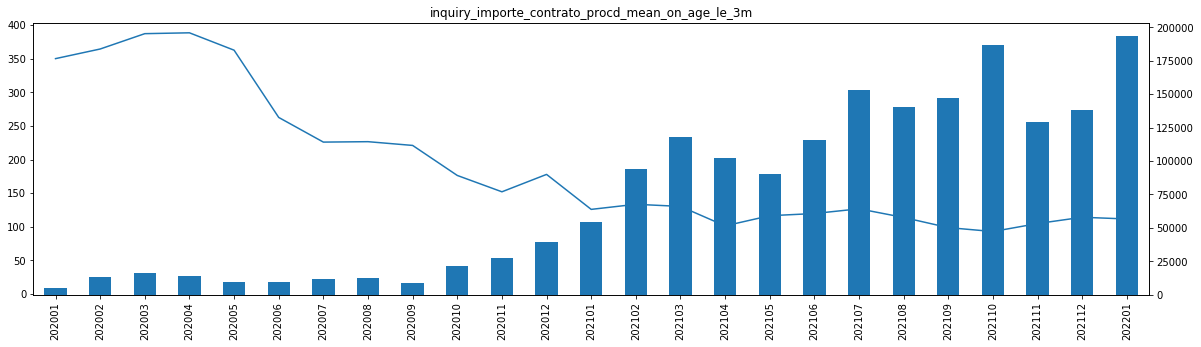

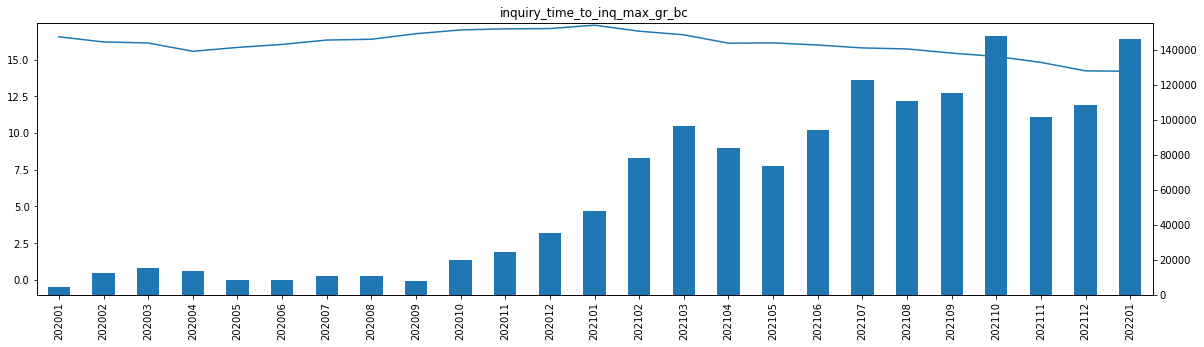

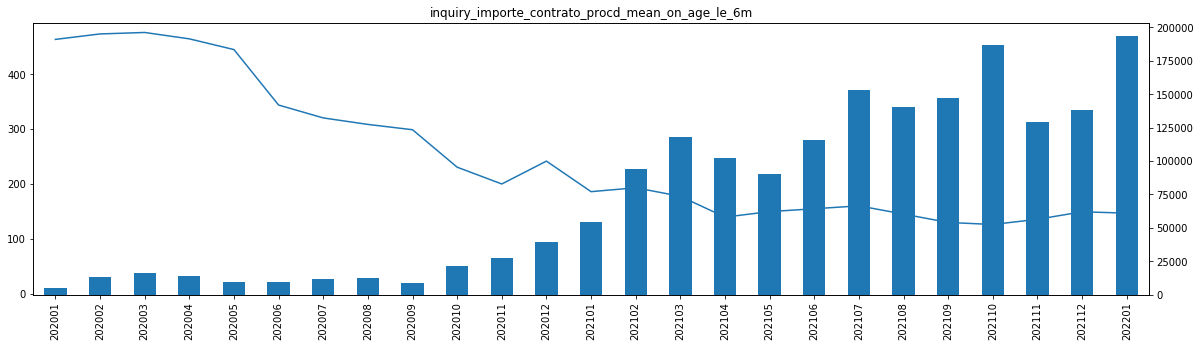

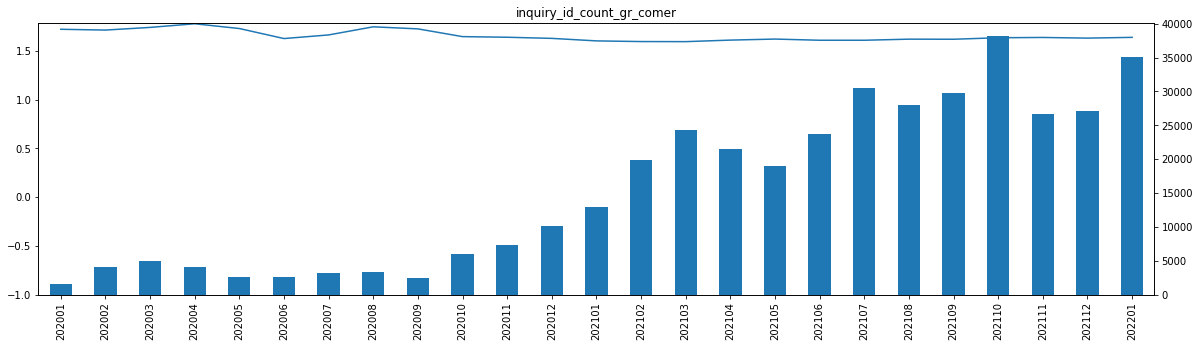

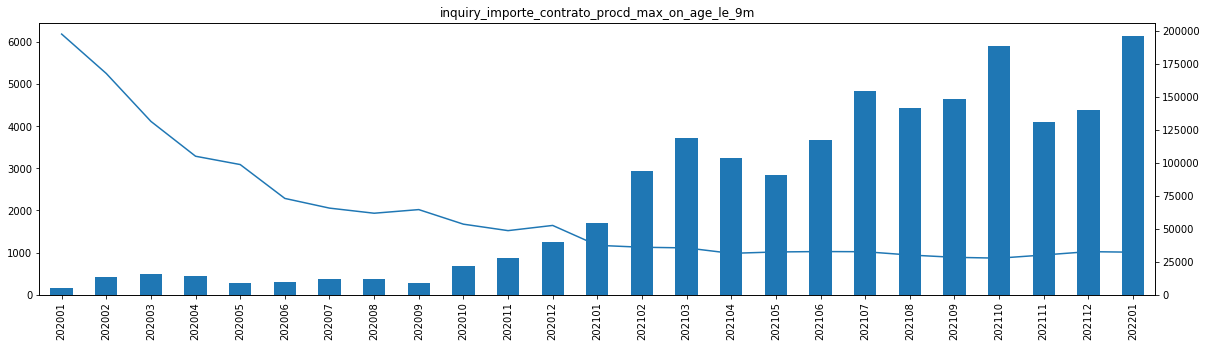

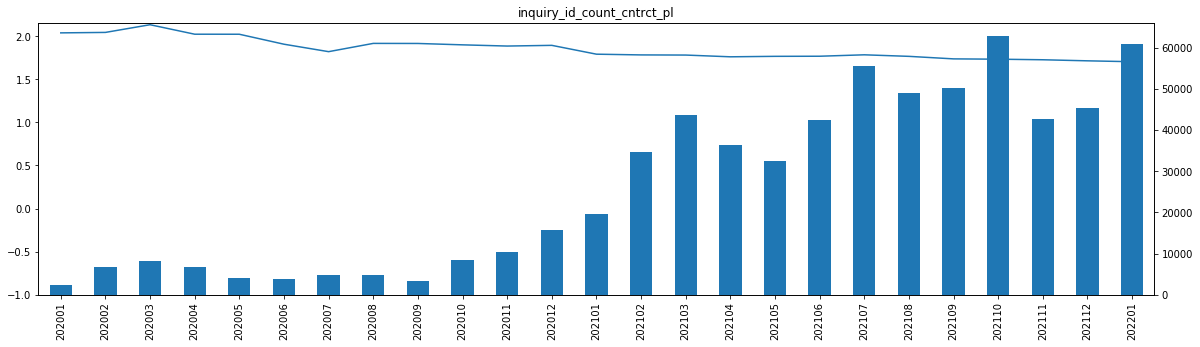

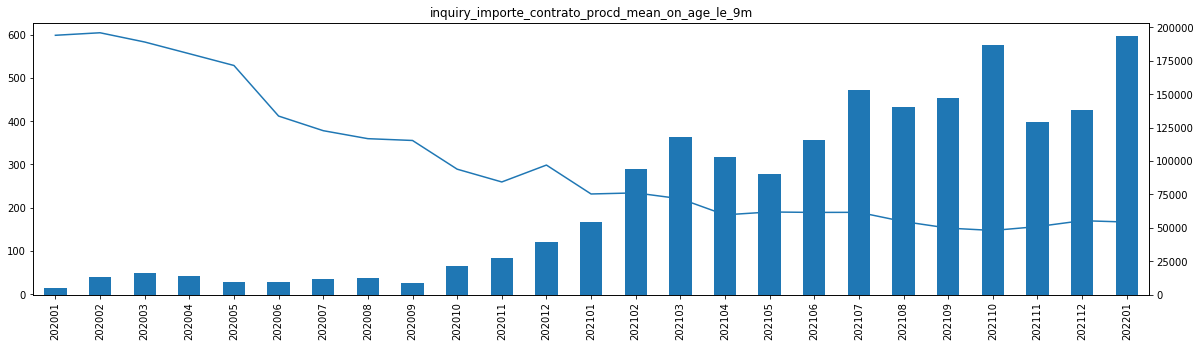

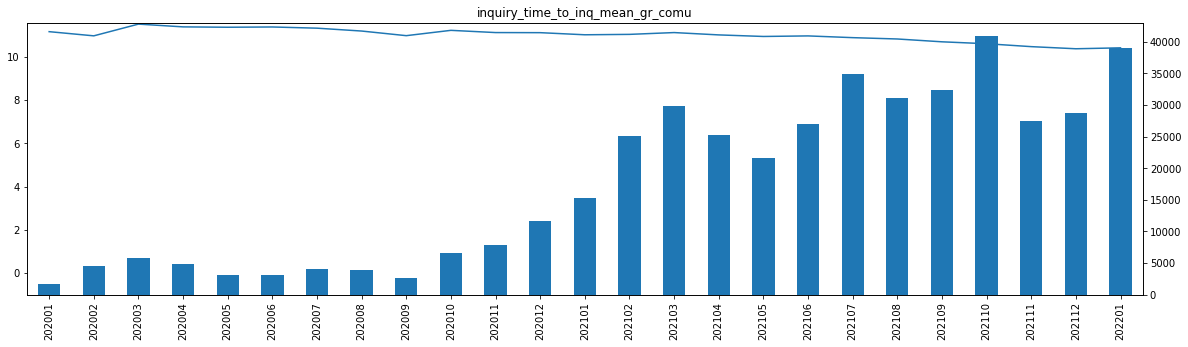

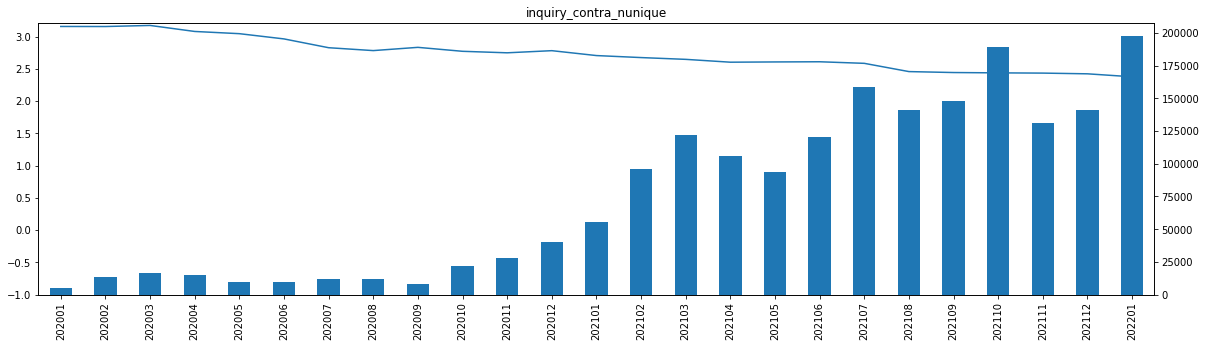

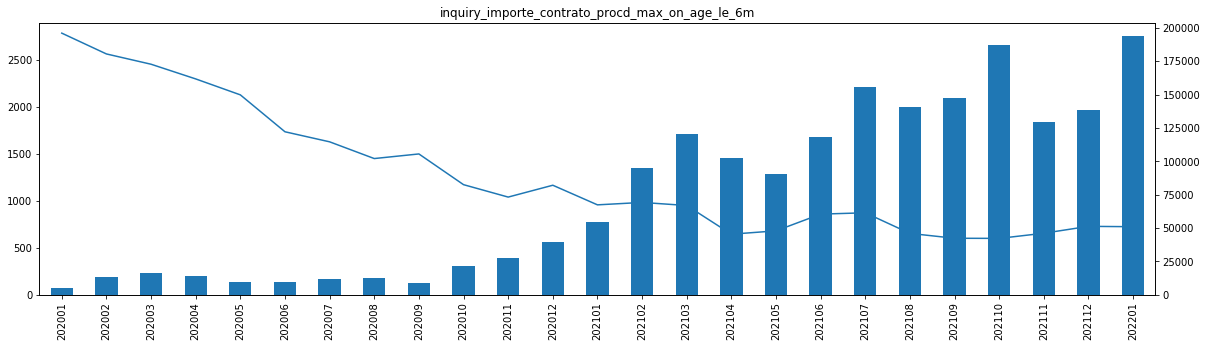

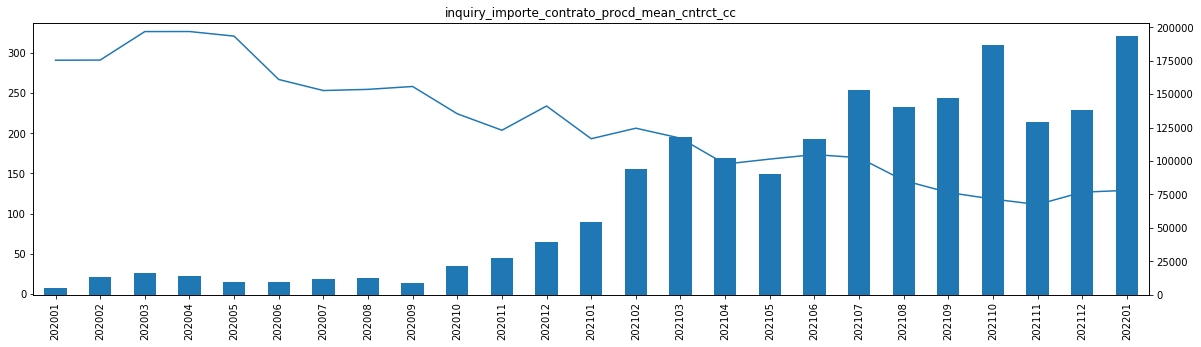

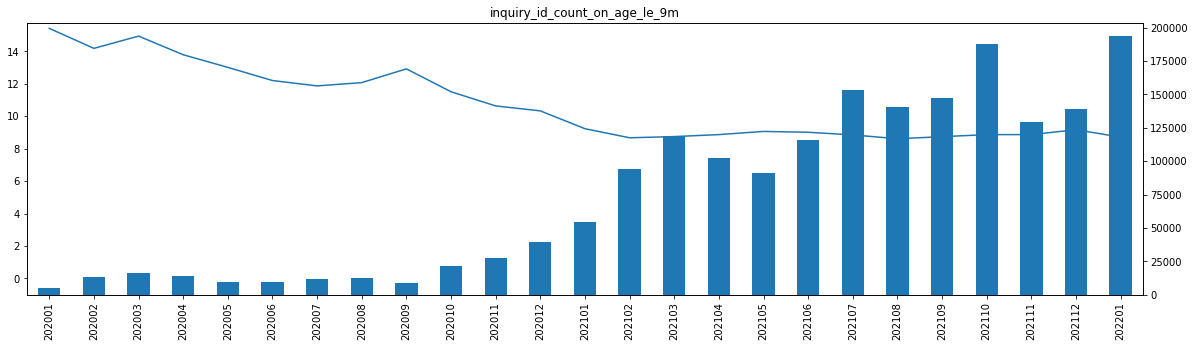

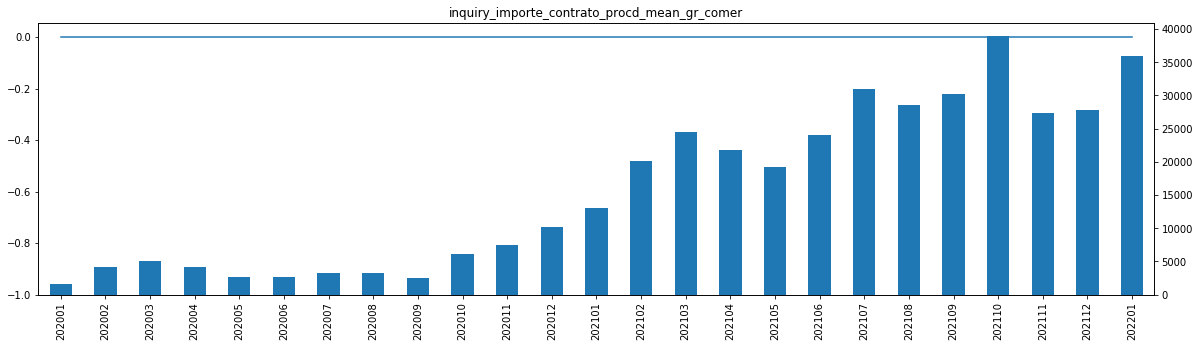

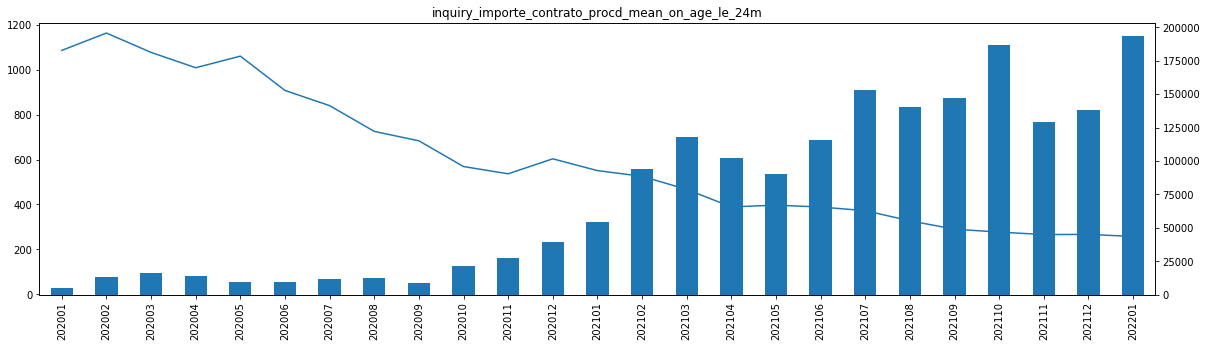

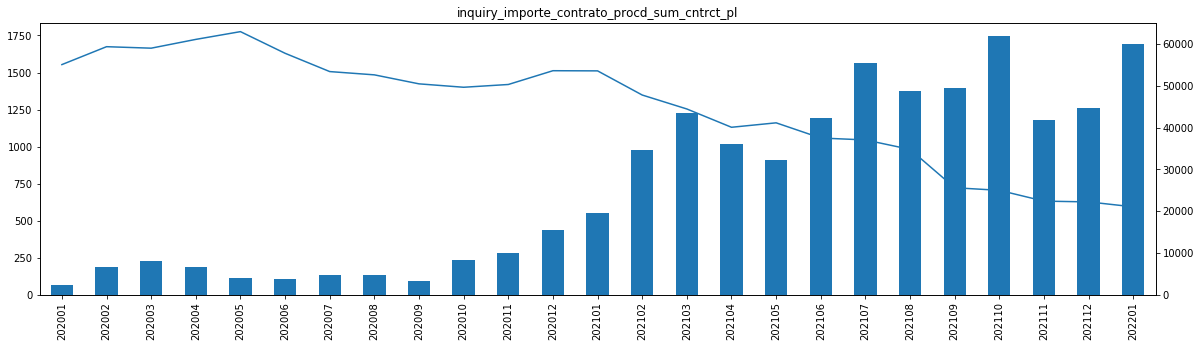

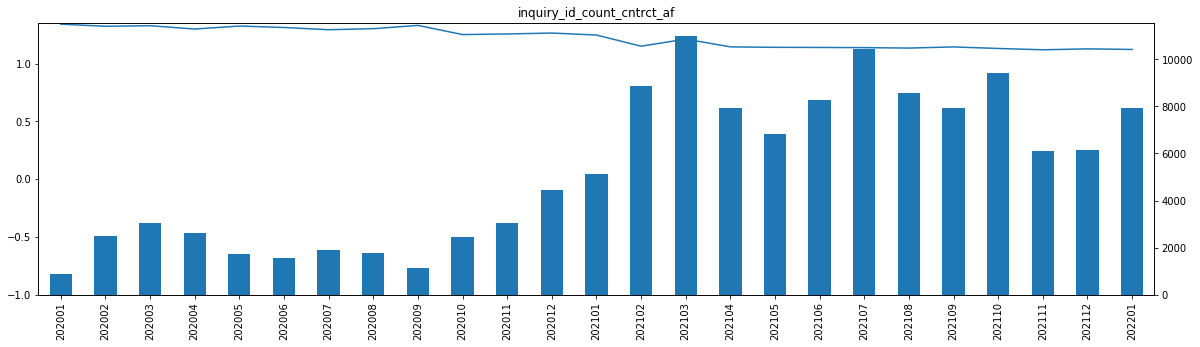

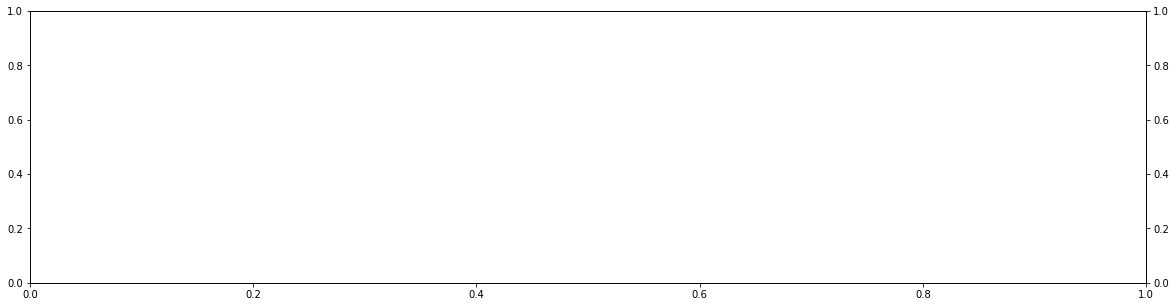

In [158]:
import matplotlib.pyplot as plt
inquiry_features = [x for x in ecrm_all.columns if ('inquiry' in x)]
for f in inquiry_features:
    fig, ax = plt.subplots(figsize=(20,5))
    ax1 = ax.twinx()
    max_ = ecrm_all[ecrm_all[f]>=0][[f, 'month_of_year']].groupby('month_of_year').quantile(0.95).sort_values('month_of_year').reset_index()
    plt_df_raw = ecrm_all[[f, 'month_of_year']].merge(max_, on='month_of_year', suffixes=['', '_max'])
    # remove outlier by removing the max. 
    plt_df = plt_df_raw[(plt_df_raw[f]>=0)&(plt_df_raw[f]<=(plt_df_raw[f'{f}_max']))].groupby('month_of_year')[[f]].mean().sort_values('month_of_year').reset_index()
    _=plt_df[f].plot(ax=ax)
    _=plt.xticks(np.arange(ecrm_all.month_of_year.nunique()))
    plt_df = plt_df_raw[(plt_df_raw[f]>=0)&(plt_df_raw[f]<=(plt_df_raw[f'{f}_max']))].groupby('month_of_year').agg({f:'size'}).sort_values('month_of_year').reset_index()
    _=plt_df[f].plot.bar(ax=ax1)
    _=plt.xticks(np.arange(ecrm_all.month_of_year.nunique()))
    start, end = ax.get_ylim()
    _=ax.set_ylim(-1, end)
#     _=ax.xaxis.set_ticks(np.arange(start, end, 1))
    label = list(plt_df.month_of_year)
    label.sort()
    _=ax.set_xticklabels(label, rotation=90)
    _=ax.set_title(f)

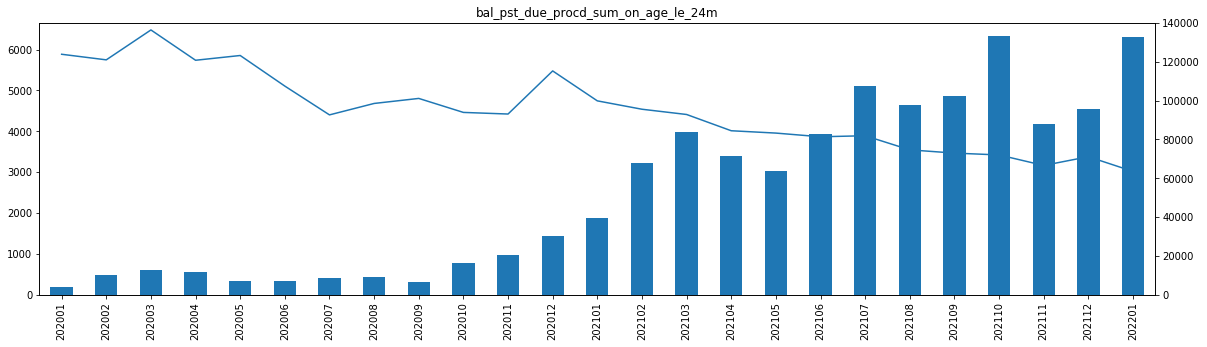

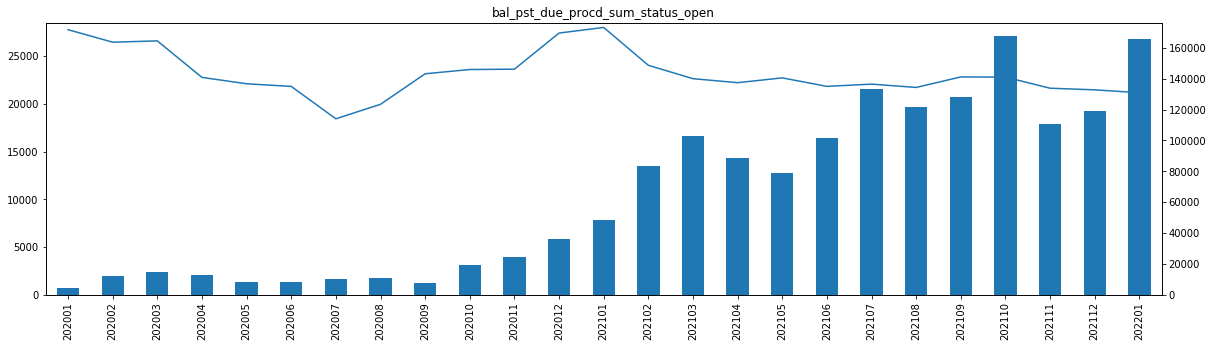

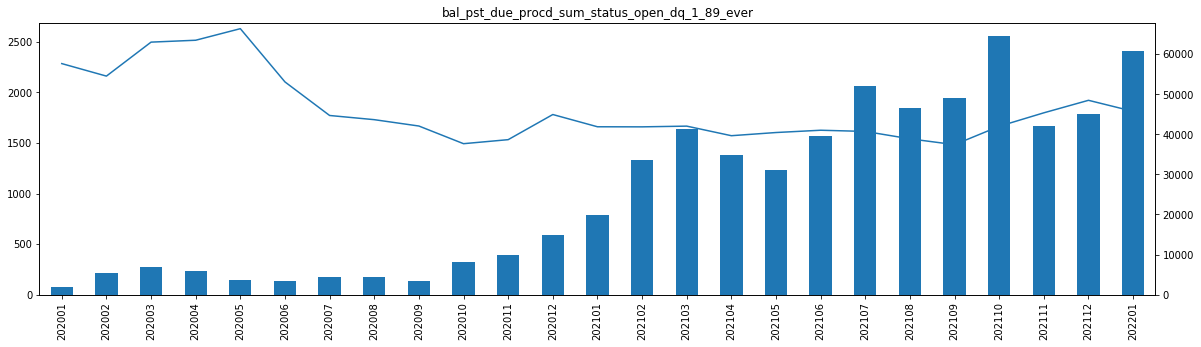

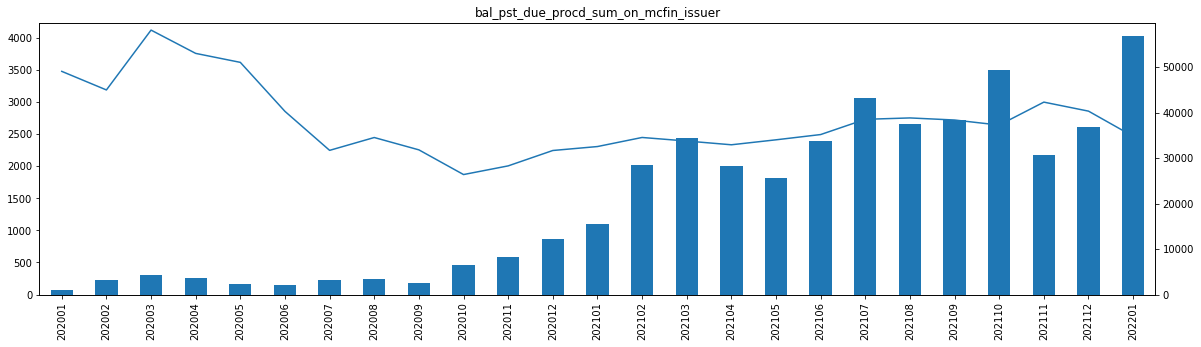

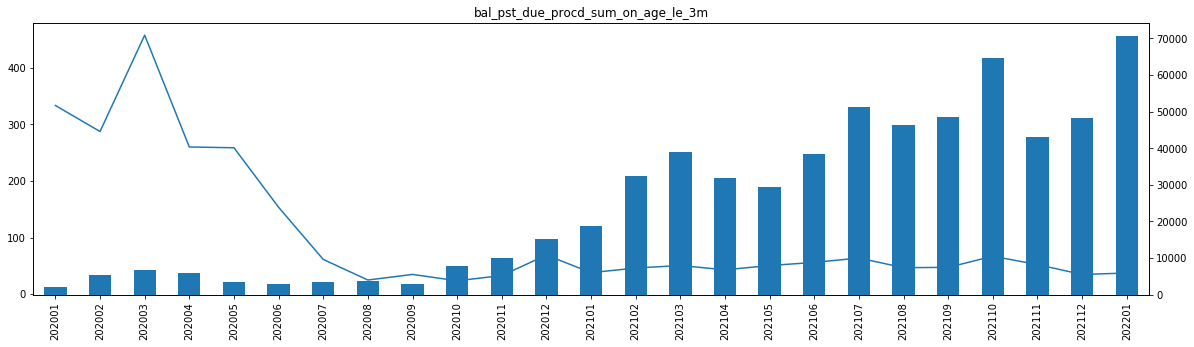

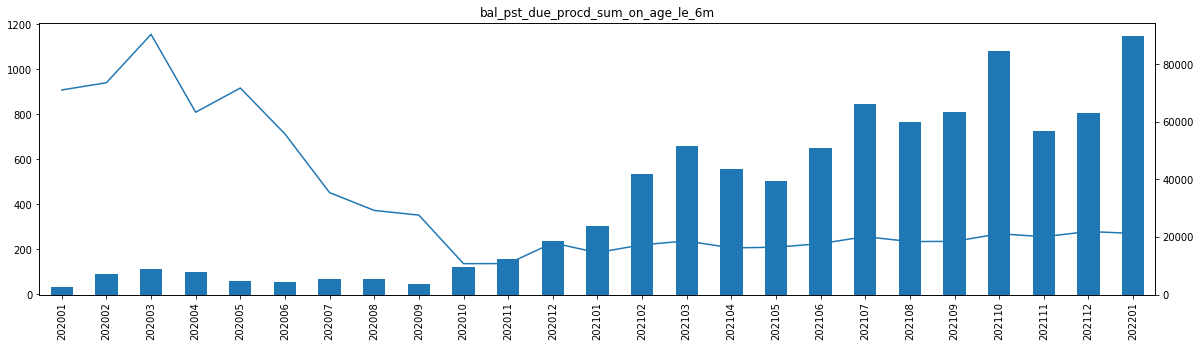

In [80]:
import matplotlib.pyplot as plt
inquiry_features = [x for x in ecrm_all.columns if ('bal_pst_due' in x)&('max' not in x)]
for f in inquiry_features:
    fig, ax = plt.subplots(figsize=(20,5))
    ax1 = ax.twinx()
    max_ = ecrm_all[ecrm_all[f]>=0][[f, 'month_of_year']].groupby('month_of_year').quantile(0.95).sort_values('month_of_year').reset_index()
    plt_df_raw = ecrm_all[[f, 'month_of_year']].merge(max_, on='month_of_year', suffixes=['', '_max'])
    # remove outlier by removing the max. 
    plt_df = plt_df_raw[(plt_df_raw[f]>=0)&(plt_df_raw[f]<=(plt_df_raw[f'{f}_max']))].groupby('month_of_year')[[f]].mean().sort_values('month_of_year').reset_index()
    _=plt_df[f].plot(ax=ax)
    _=plt.xticks(np.arange(ecrm_all.month_of_year.nunique()))
    plt_df = plt_df_raw[(plt_df_raw[f]>=0)&(plt_df_raw[f]<=(plt_df_raw[f'{f}_max']))].groupby('month_of_year').agg({f:'size'}).sort_values('month_of_year').reset_index()
    _=plt_df[f].plot.bar(ax=ax1)
    _=plt.xticks(np.arange(ecrm_all.month_of_year.nunique()))
    start, end = ax.get_ylim()
    _=ax.set_ylim(-1, end)
#     _=ax.xaxis.set_ticks(np.arange(start, end, 1))
    label = list(plt_df.month_of_year)
    label.sort()
    _=ax.set_xticklabels(label, rotation=90)
    _=ax.set_title(f)
    

In [122]:
ecrm_all[(ecrm_all.month_of_year=='202112')&((ecrm_all.bal_pst_due_procd_max_status_closed_gr_comer>0))].bal_pst_due_procd_max_status_closed_gr_comer.quantile(np.arange(0,1,0.05))




0.00        6.0
0.05      821.4
0.10     1095.0
0.15     1410.0
0.20     1671.2
0.25     1954.0
0.30     2436.6
0.35     3085.8
0.40     3572.4
0.45     4233.0
0.50     5213.0
0.55     6175.4
0.60     6886.6
0.65     7533.2
0.70     8467.0
0.75     9426.0
0.80    10698.8
0.85    12500.8
0.90    15166.0
0.95    21201.8
Name: bal_pst_due_procd_max_status_closed_gr_comer, dtype: float64

In [135]:
ecrm_all[(ecrm_all.month_of_year=='202112')&((ecrm_all.bal_pst_due_procd_max_status_closed_gr_comer>0))].bal_pst_due_procd_max_status_closed_gr_comer.mean()

7368.877606941696

In [134]:
ecrm_all[(ecrm_all.month_of_year=='202110')&((ecrm_all.bal_pst_due_procd_max_status_closed_gr_comer>0))].bal_pst_due_procd_max_status_closed_gr_comer.mean()


5556.755908419498

/home/lhanyun/.conda/envs/validation/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


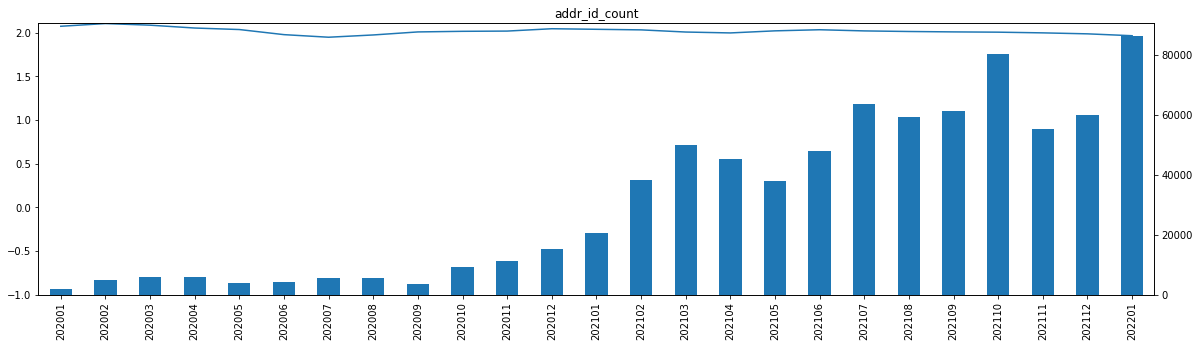

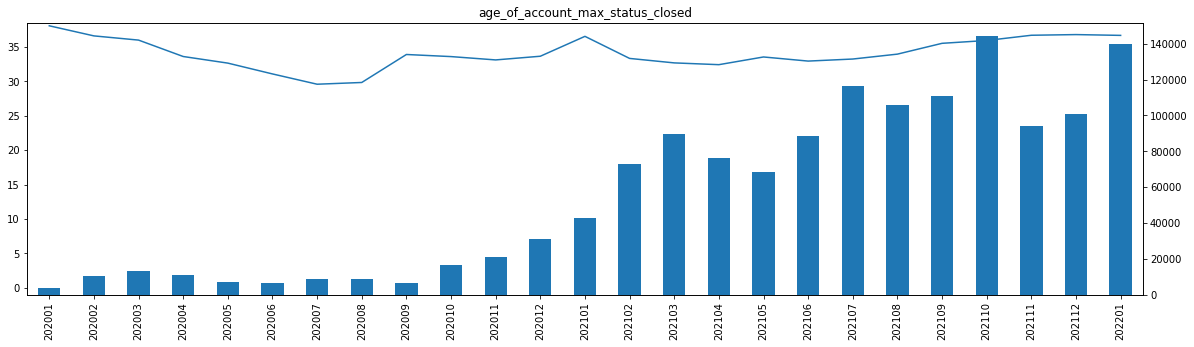

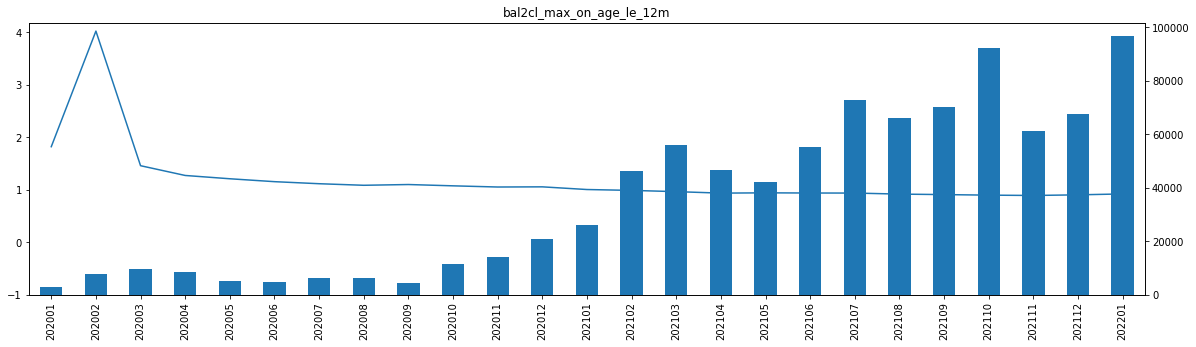

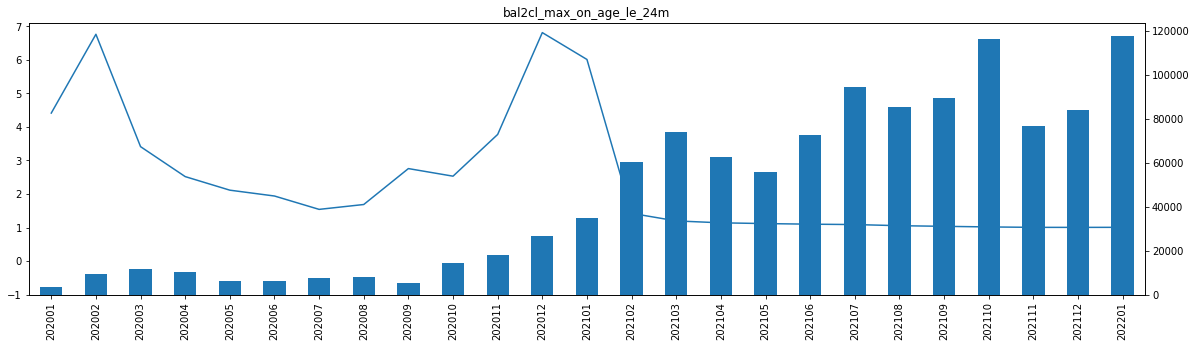

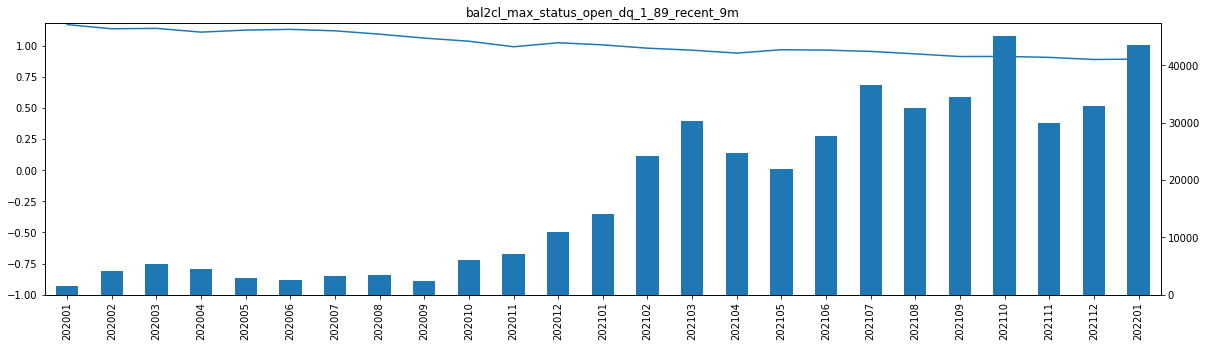

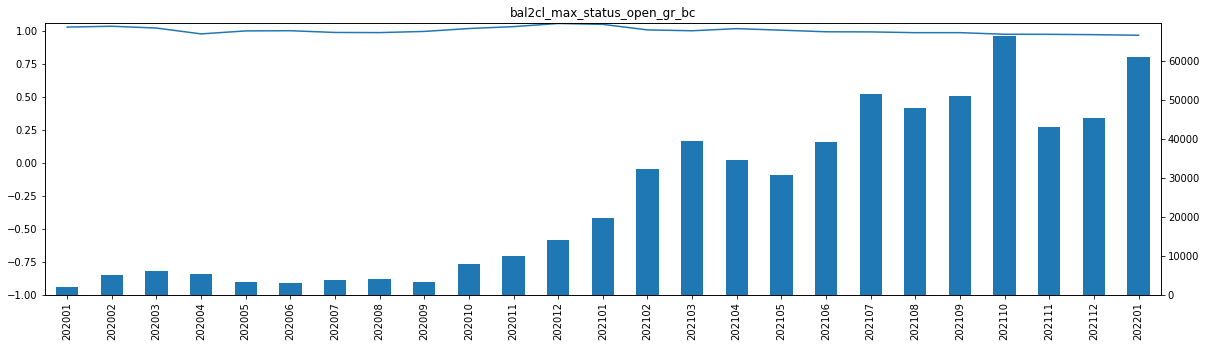

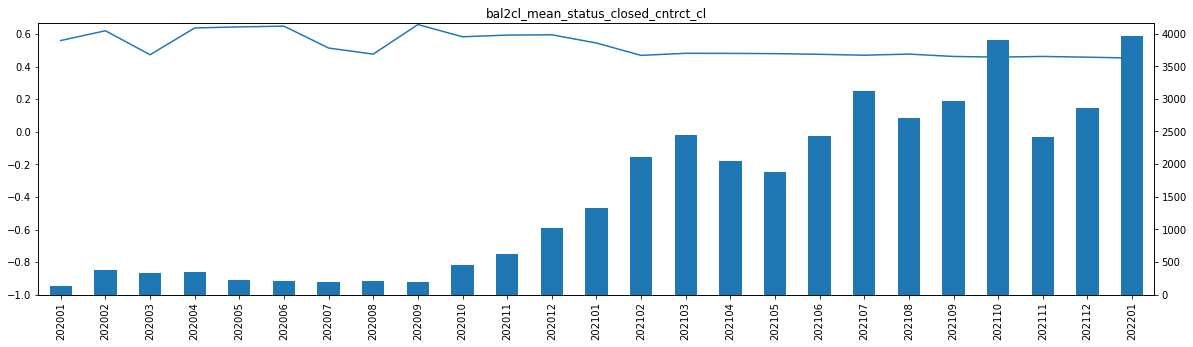

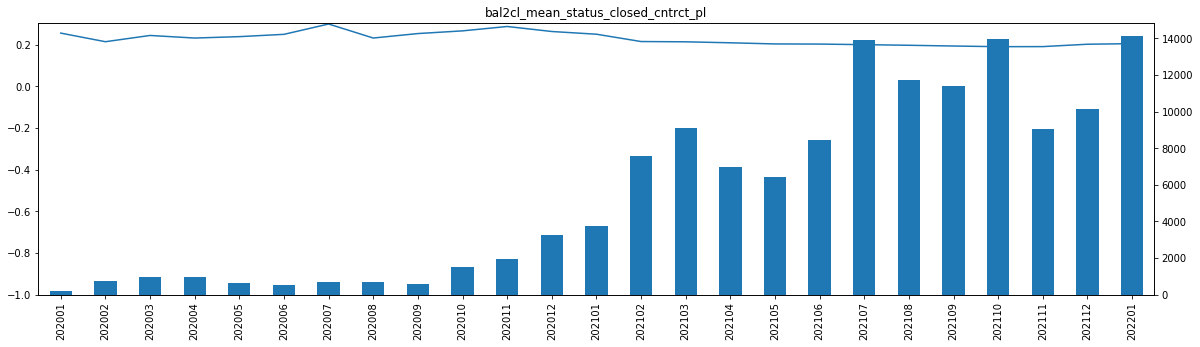

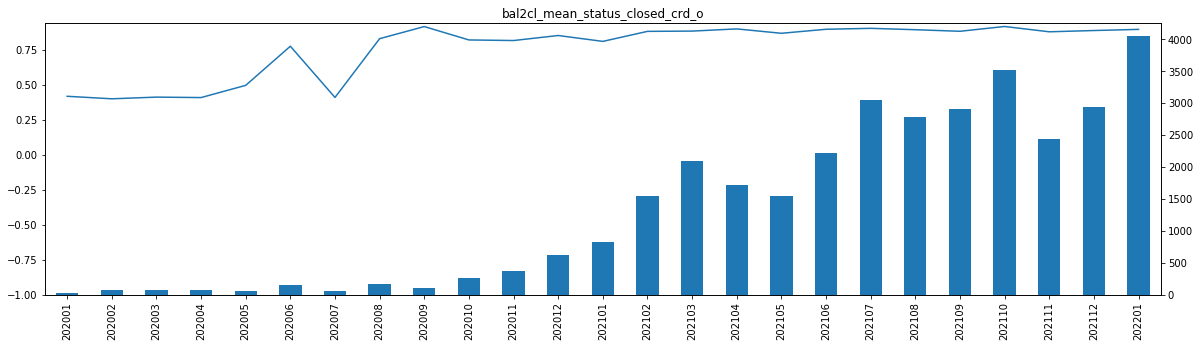

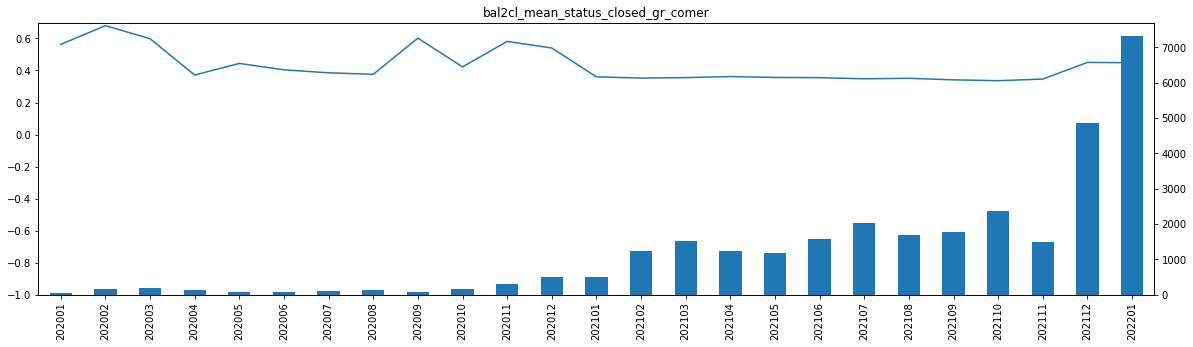

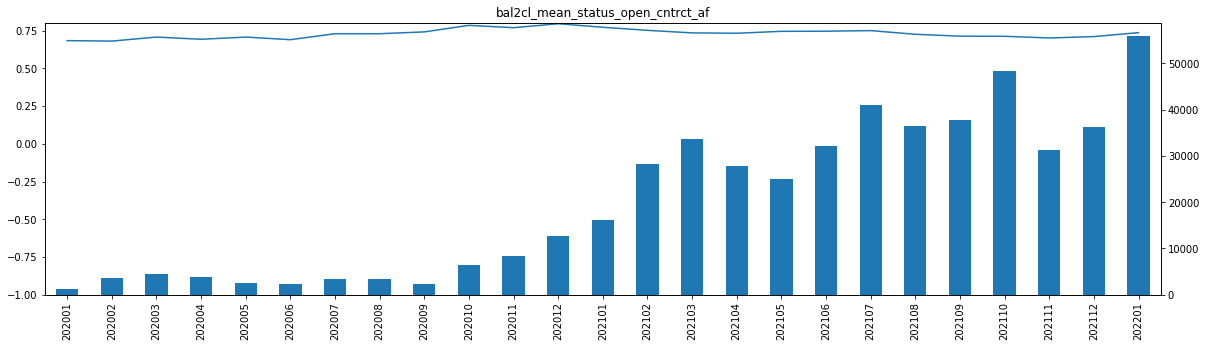

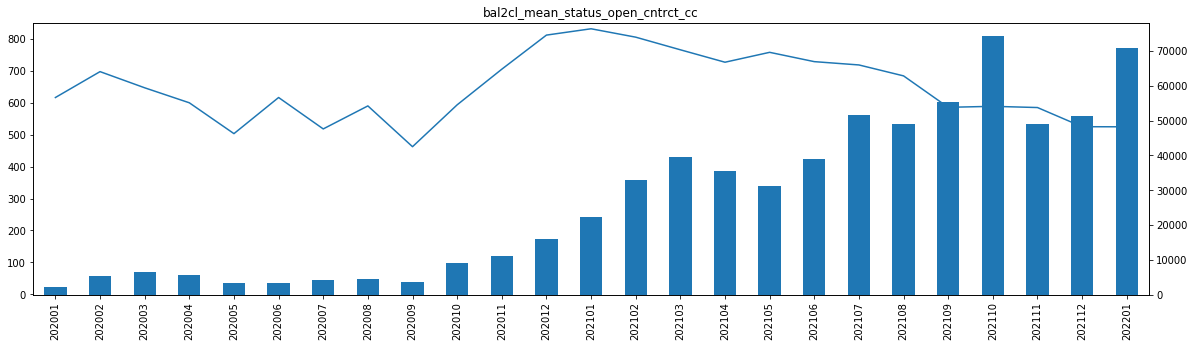

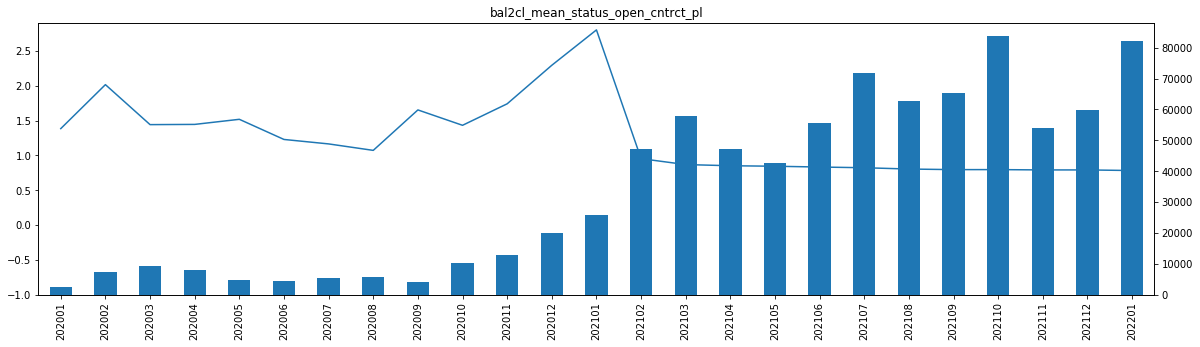

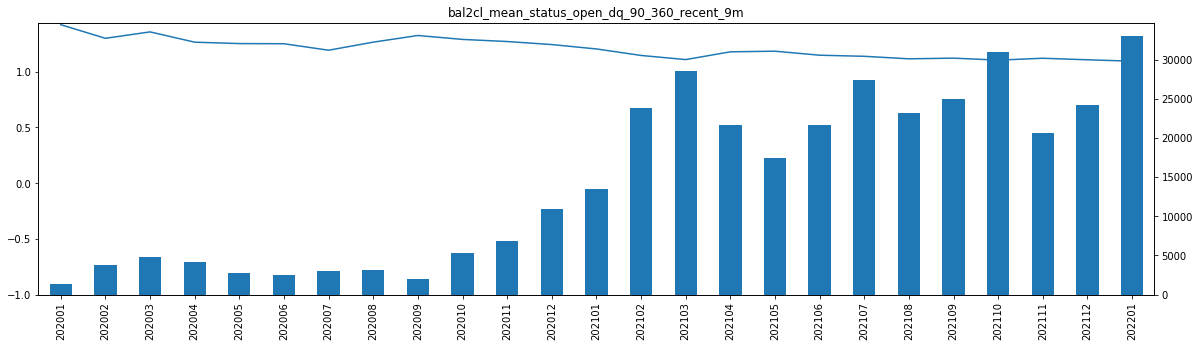

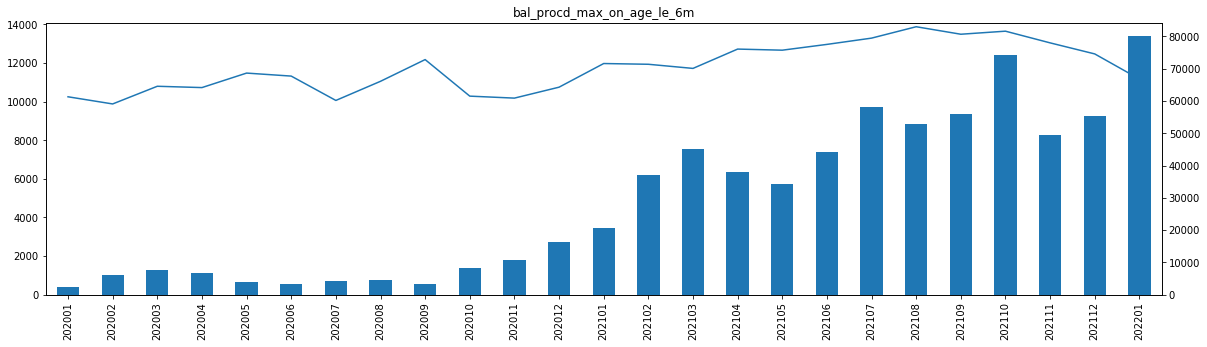

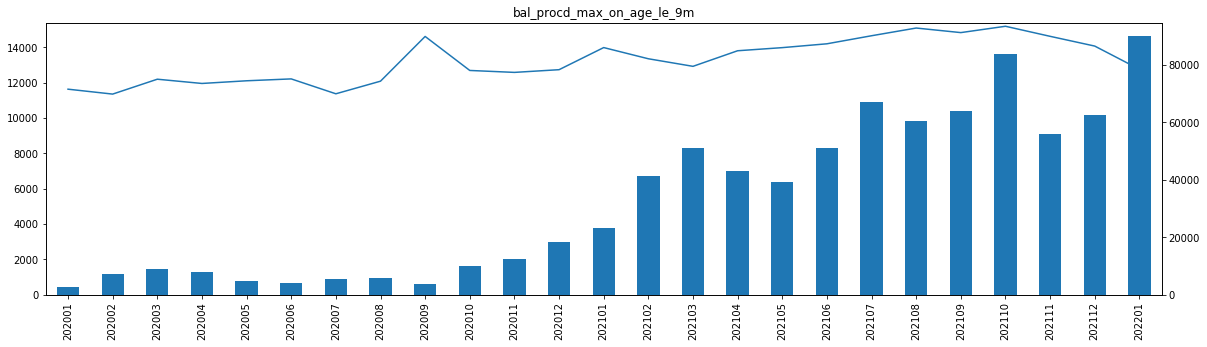

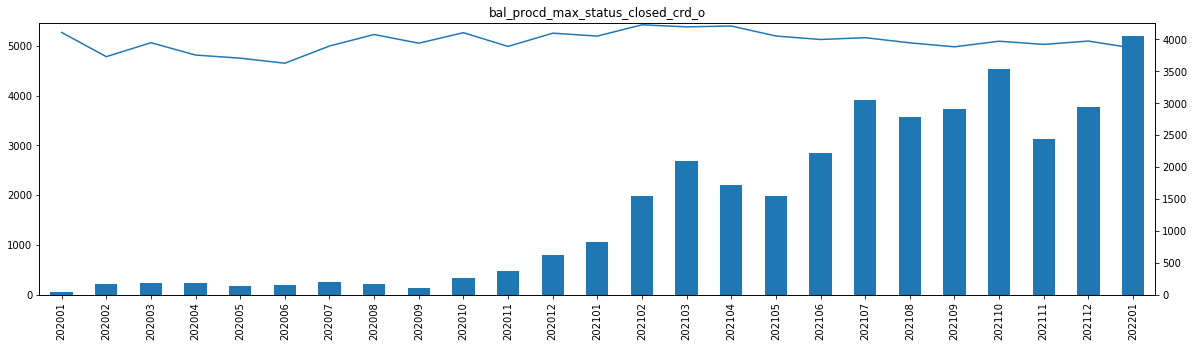

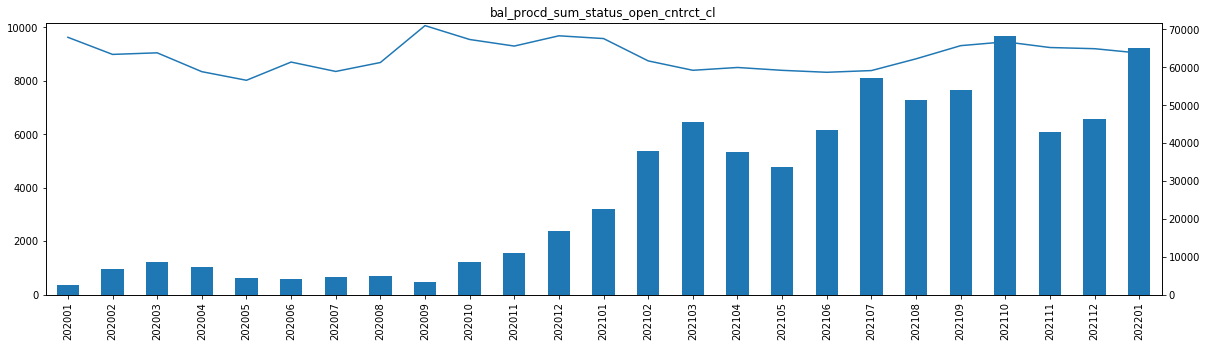

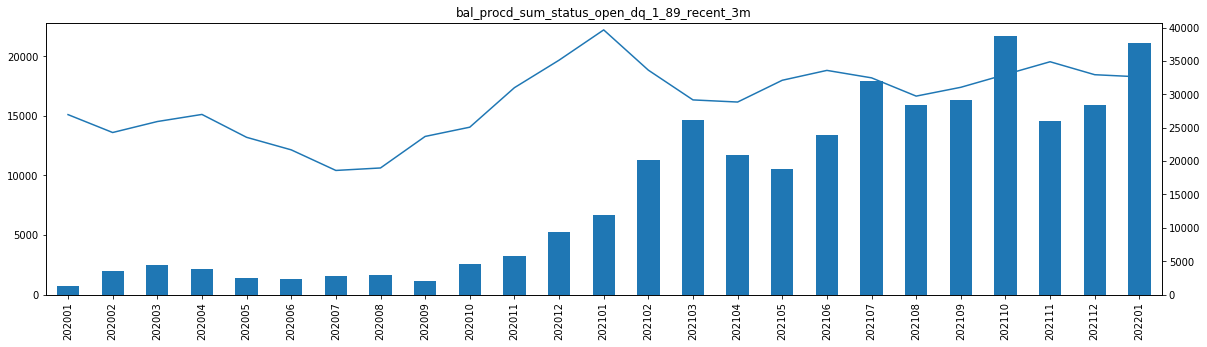

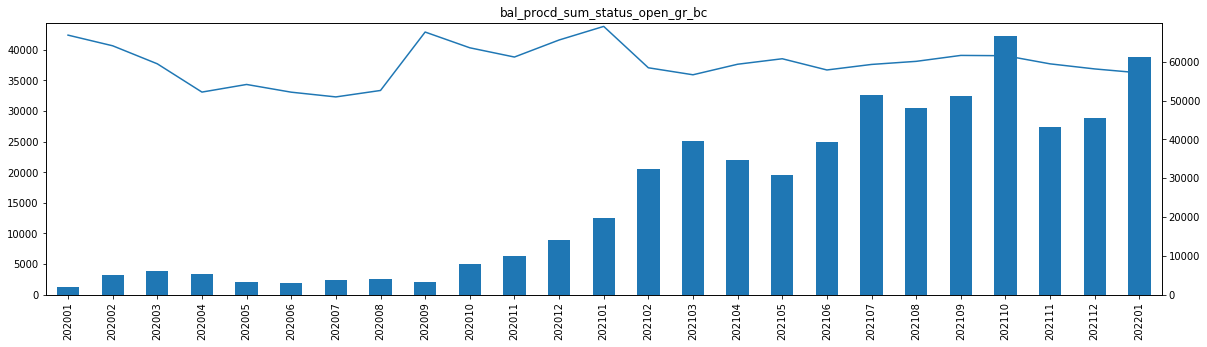

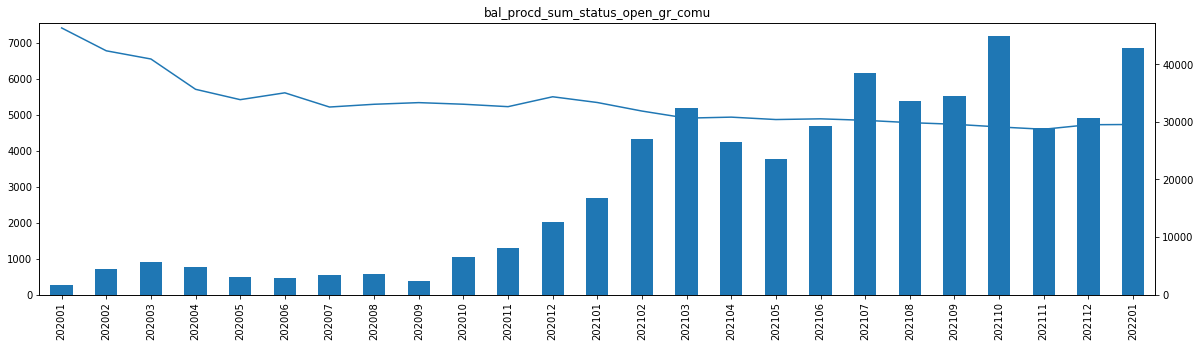

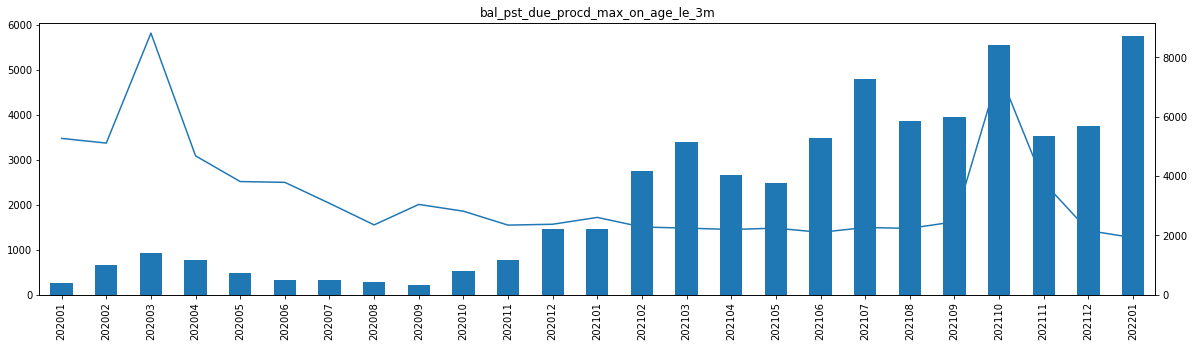

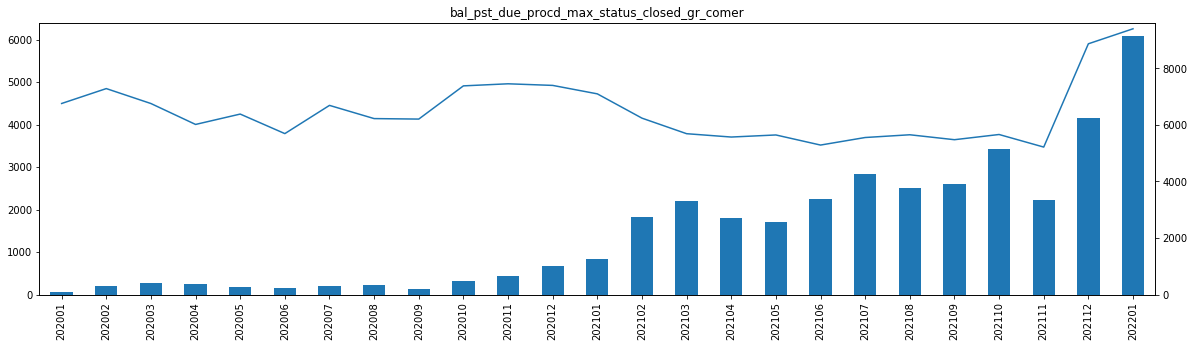

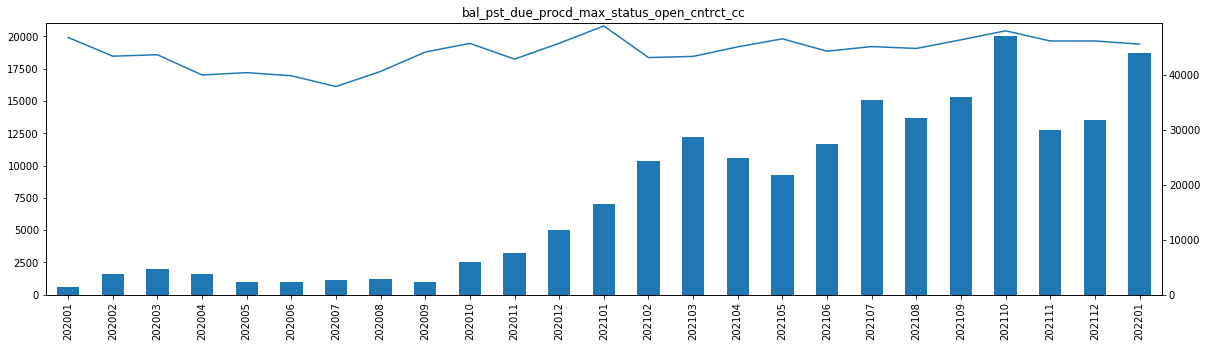

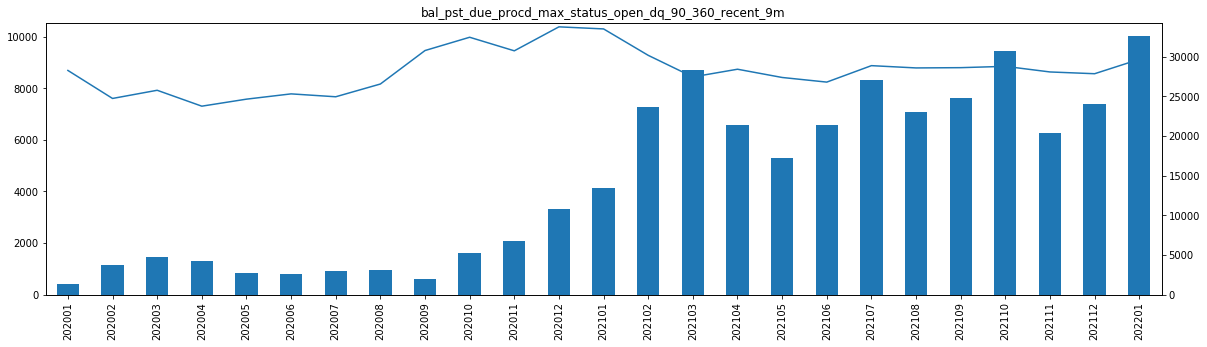

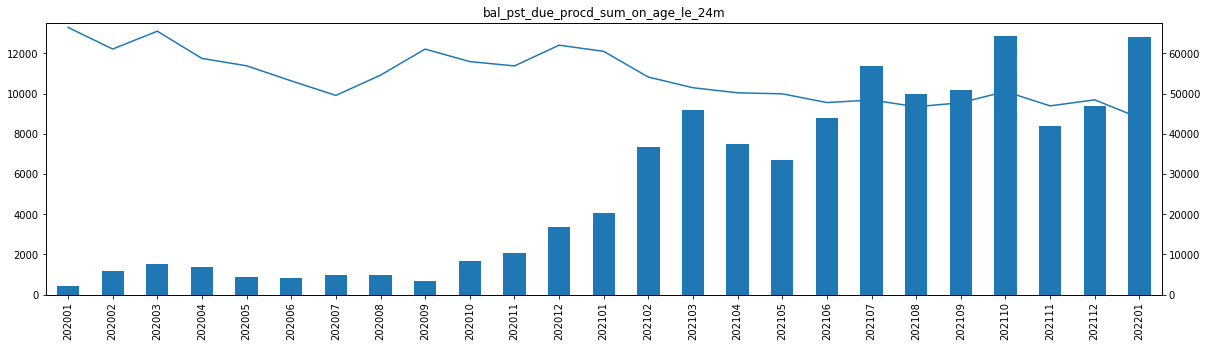

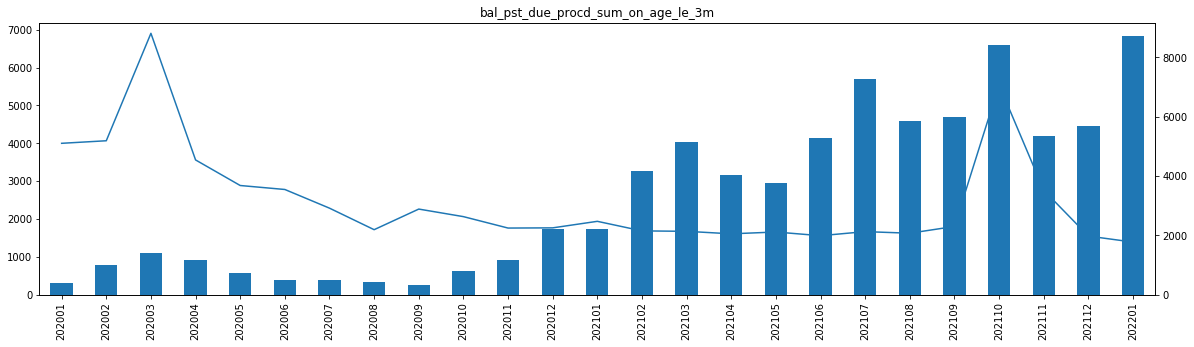

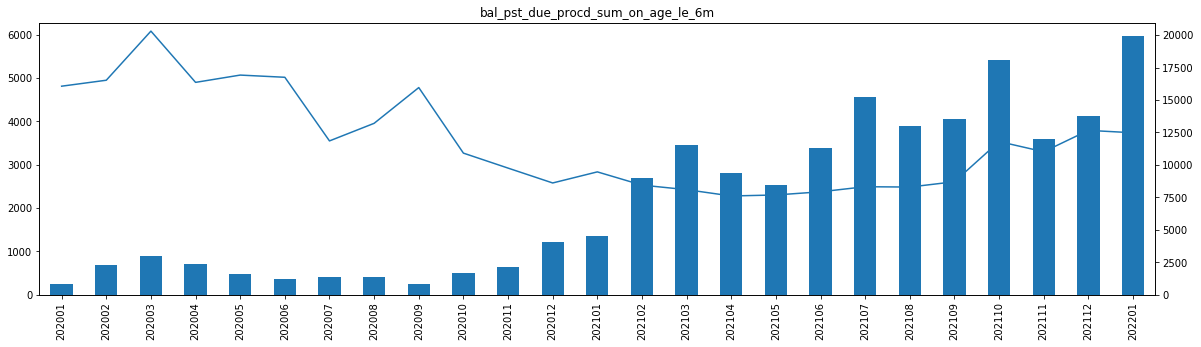

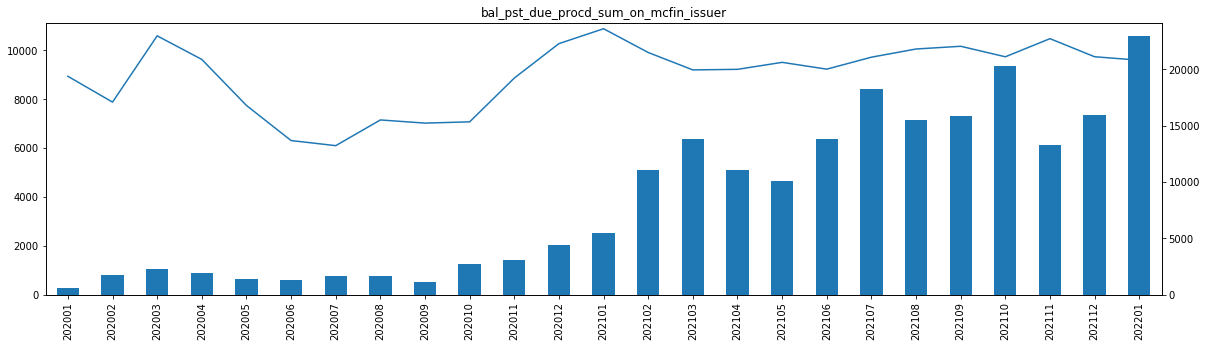

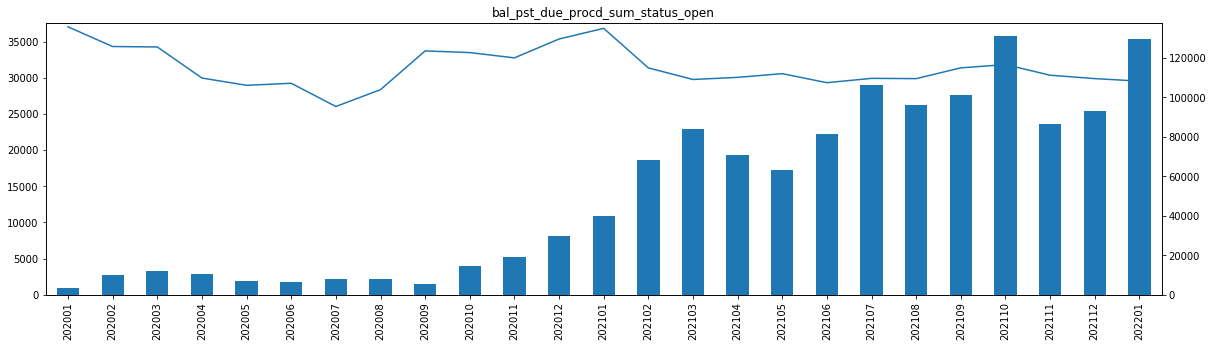

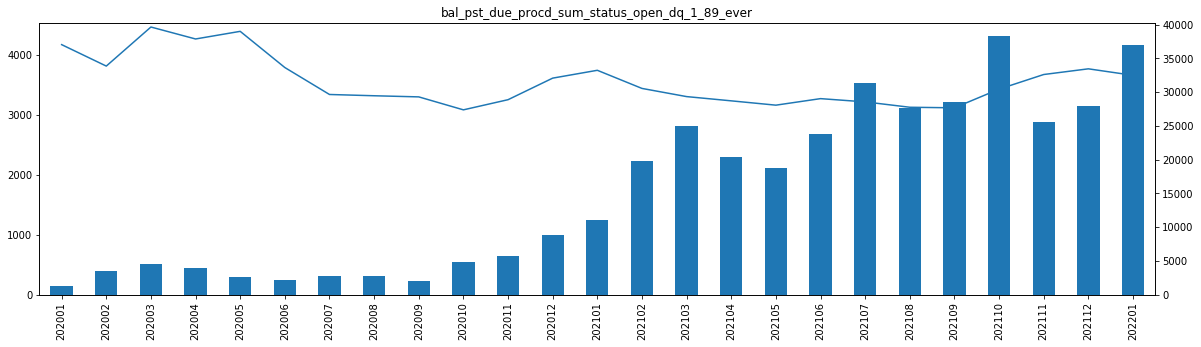

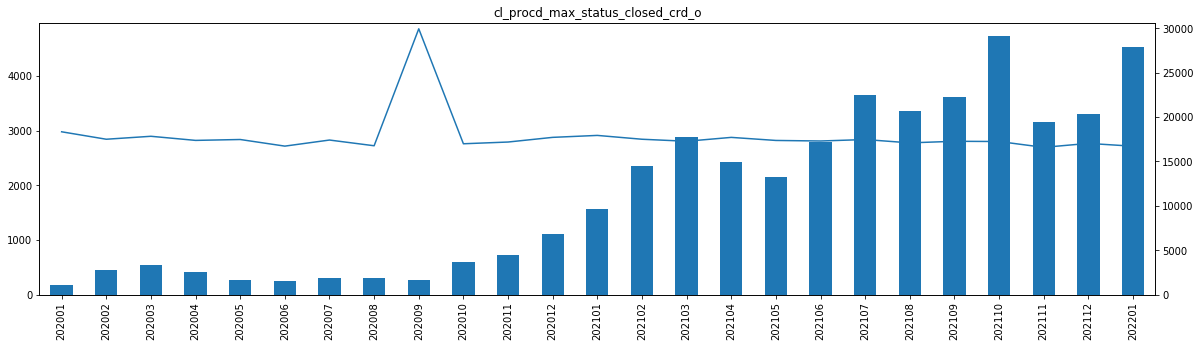

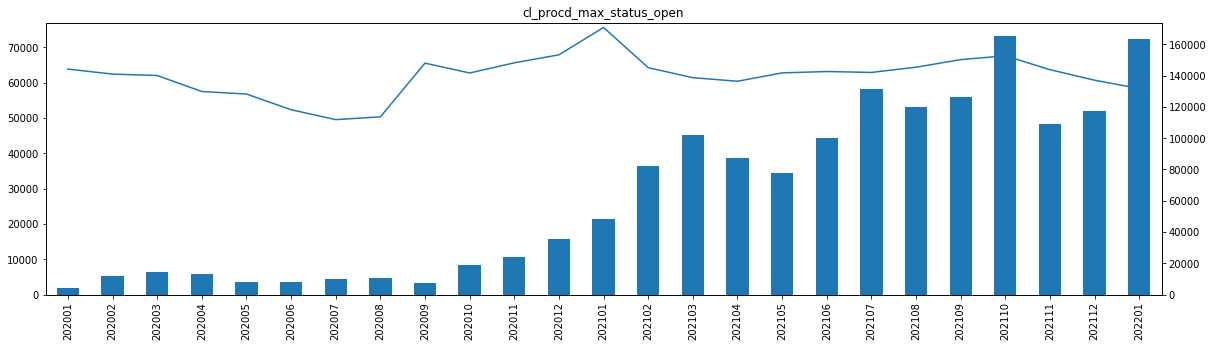

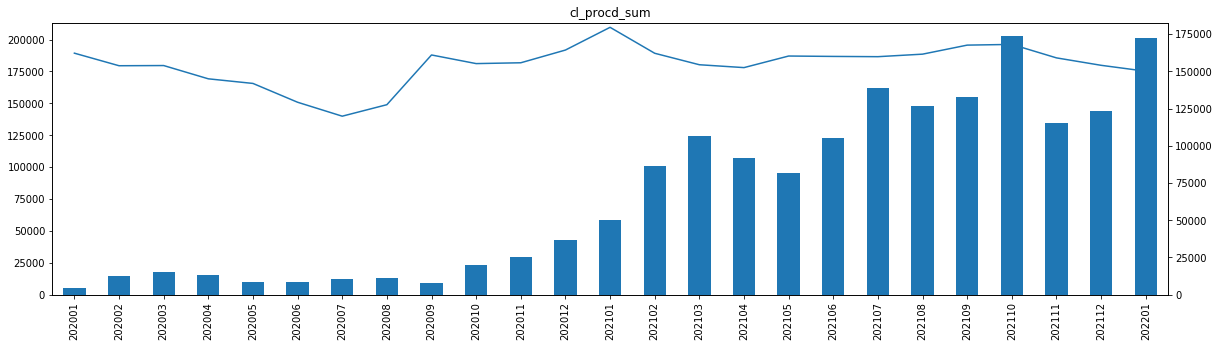

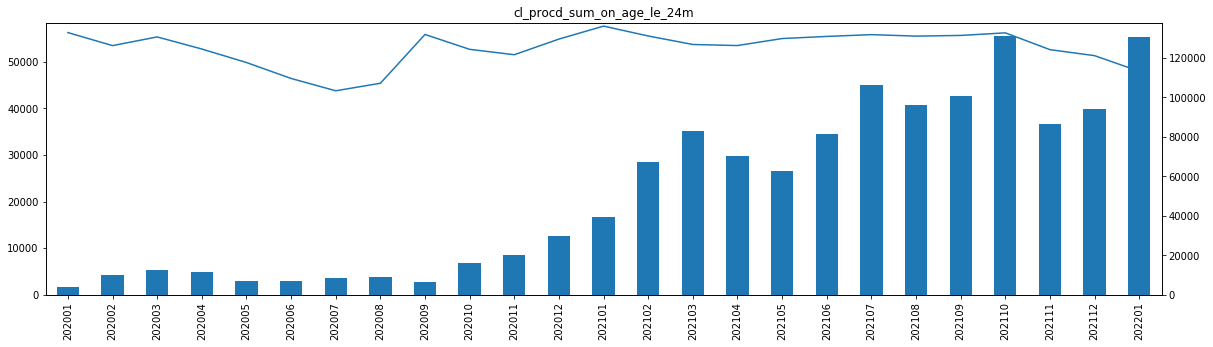

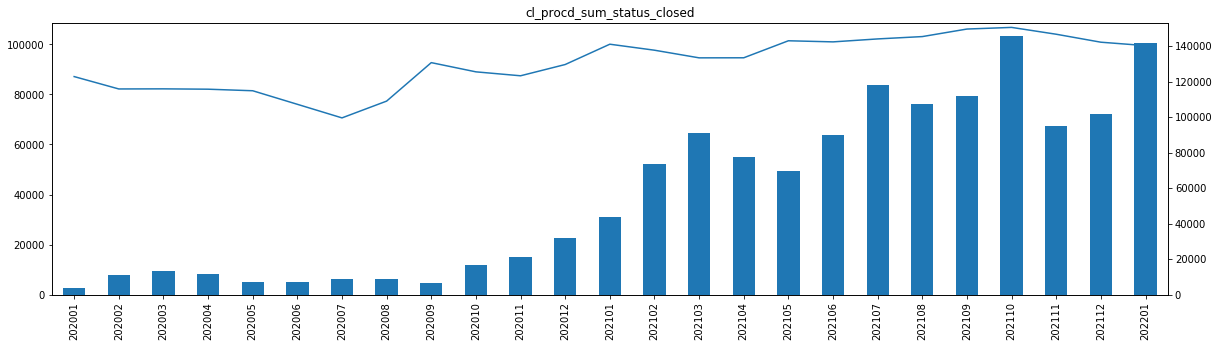

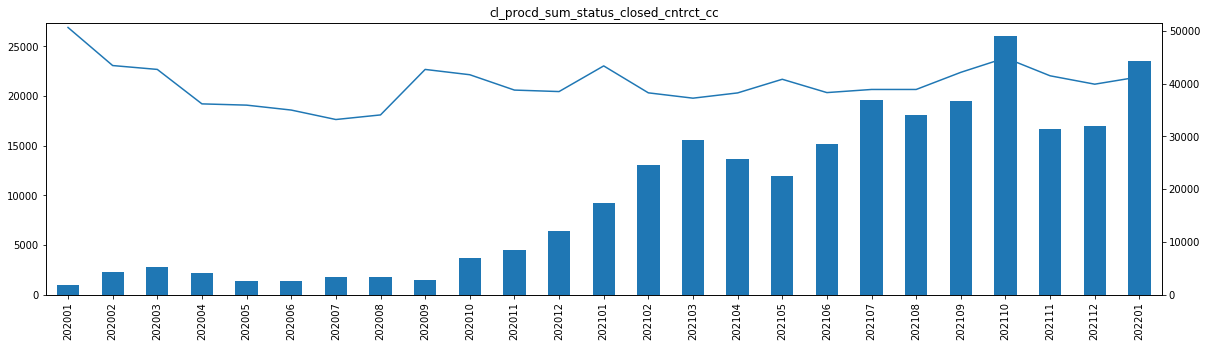

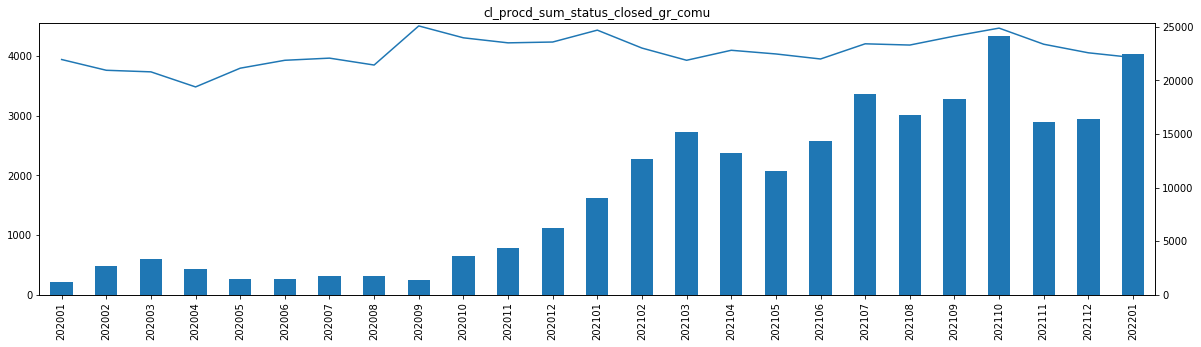

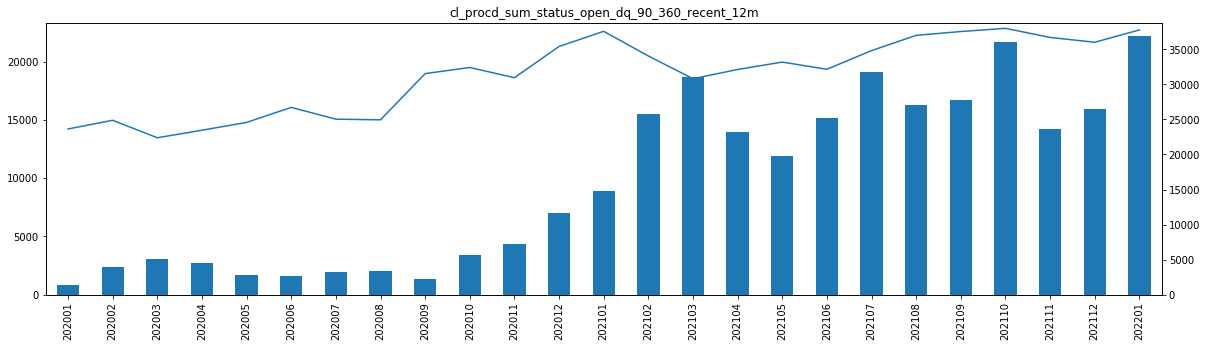

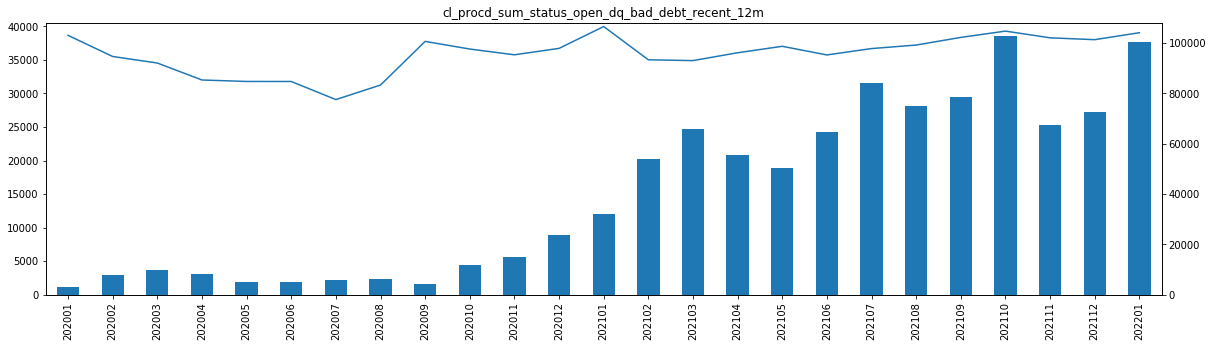

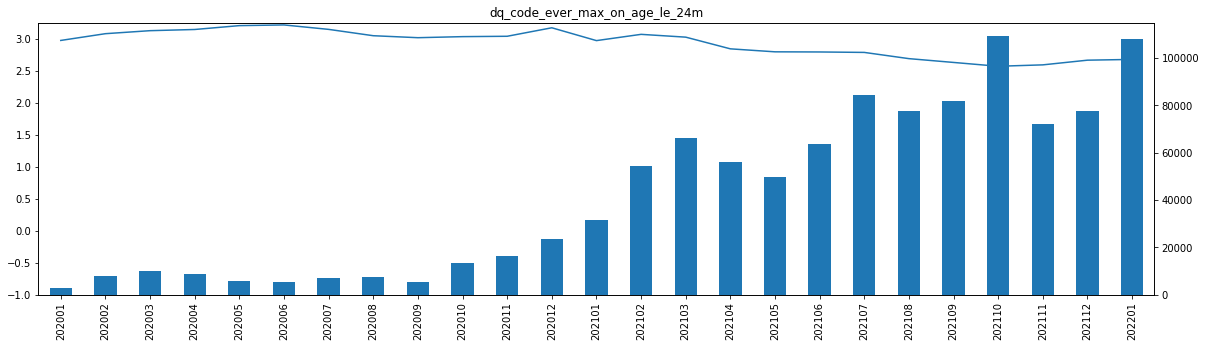

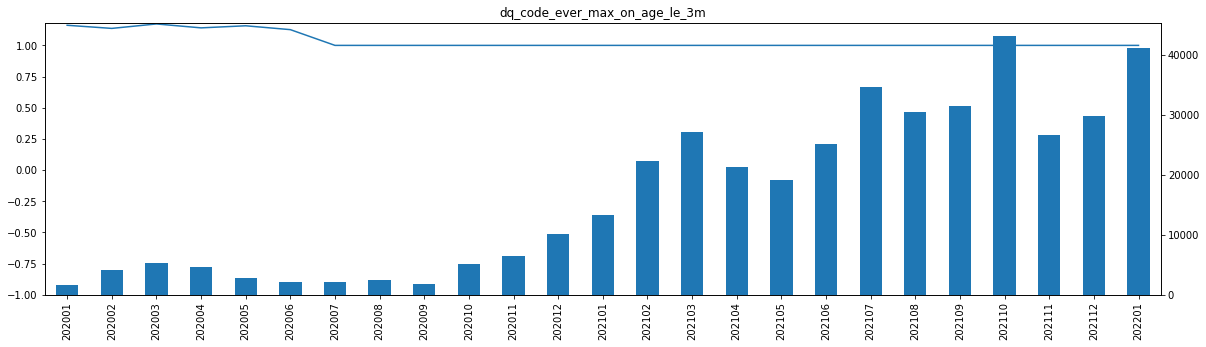

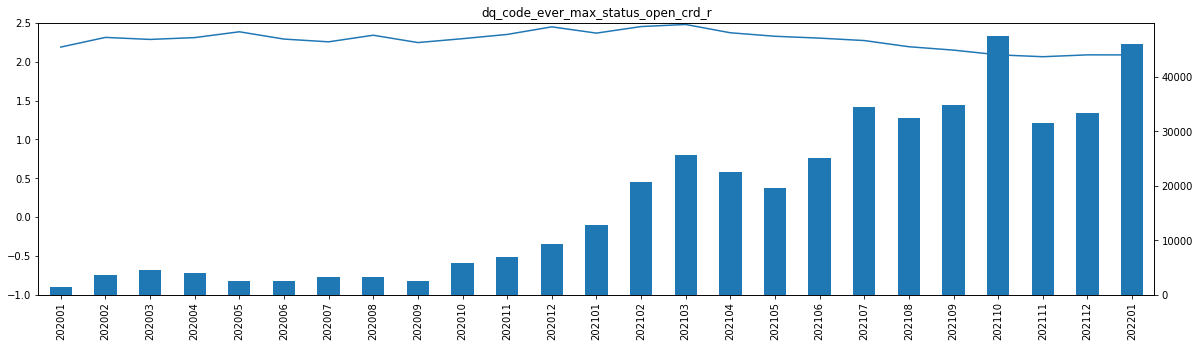

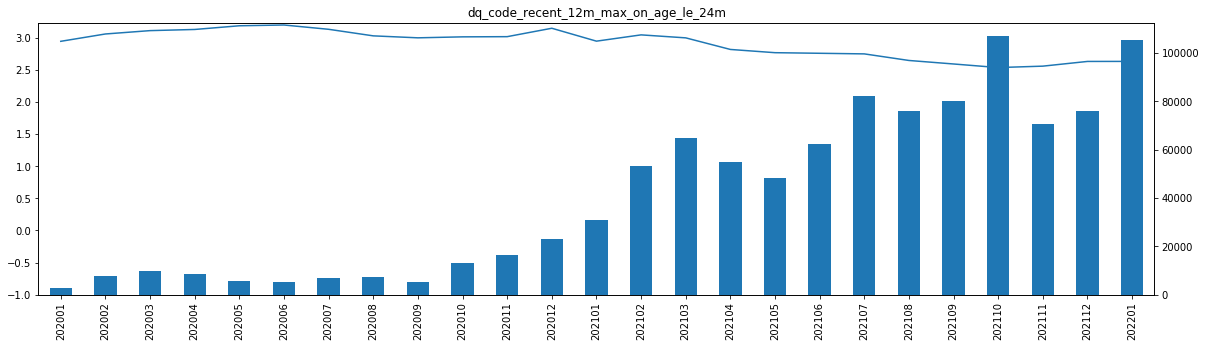

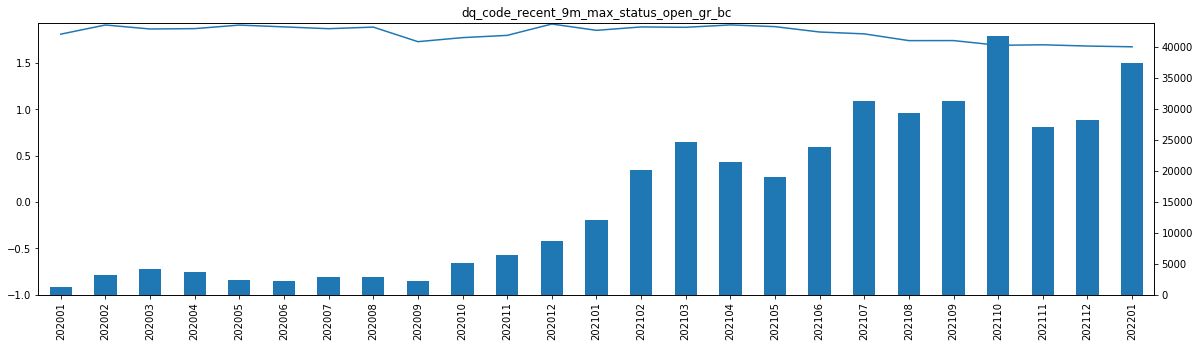

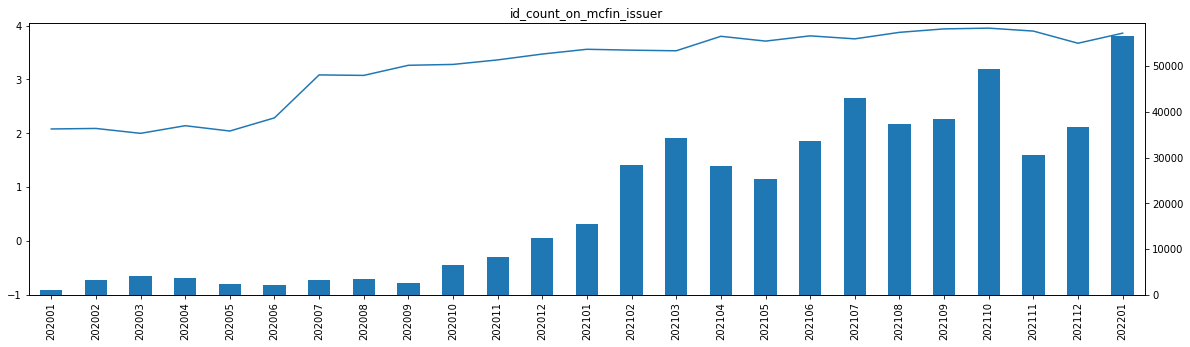

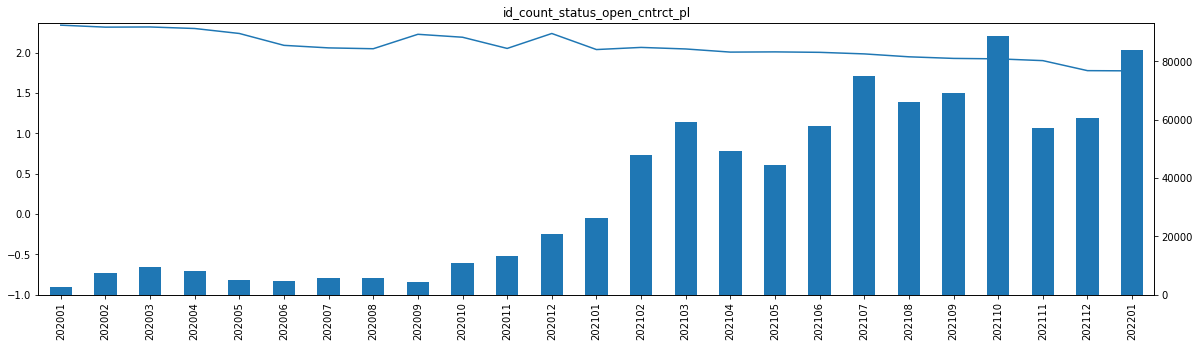

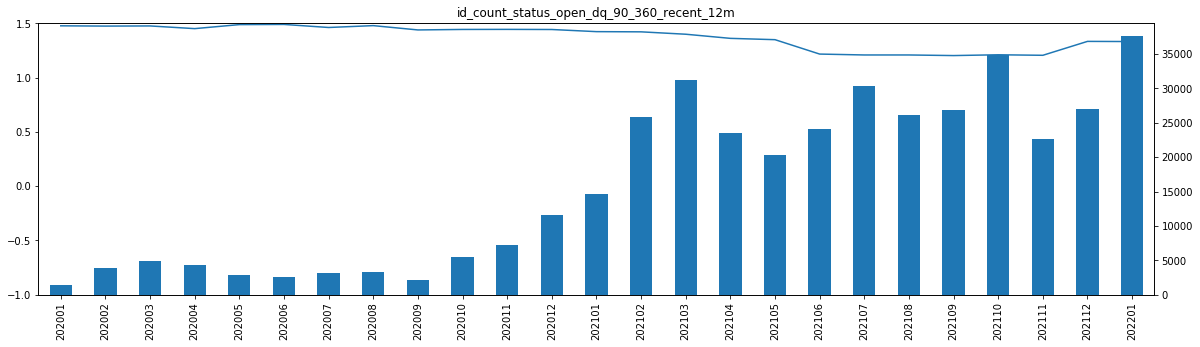

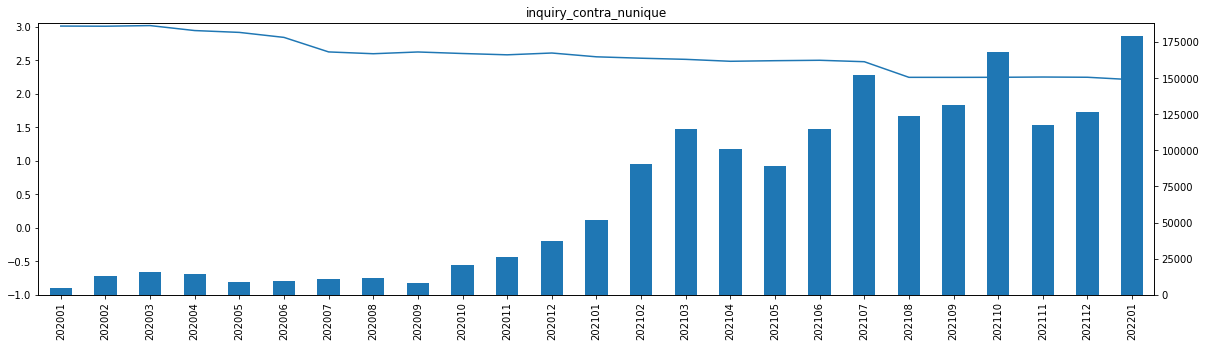

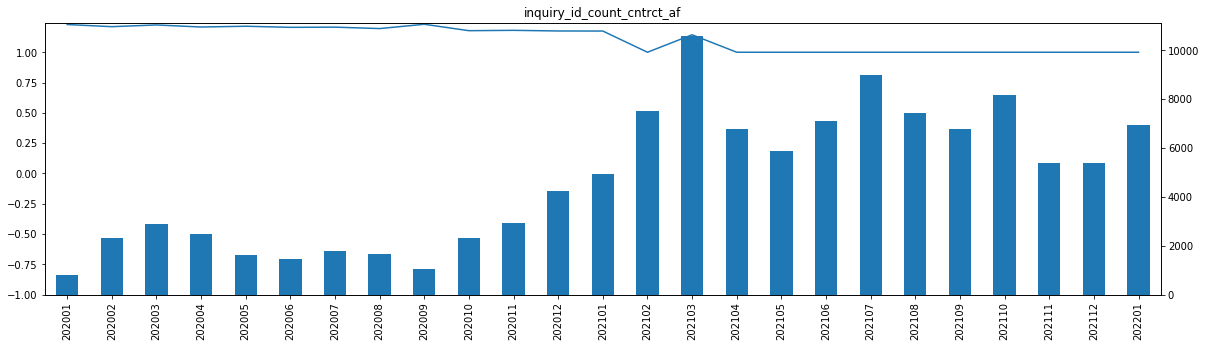

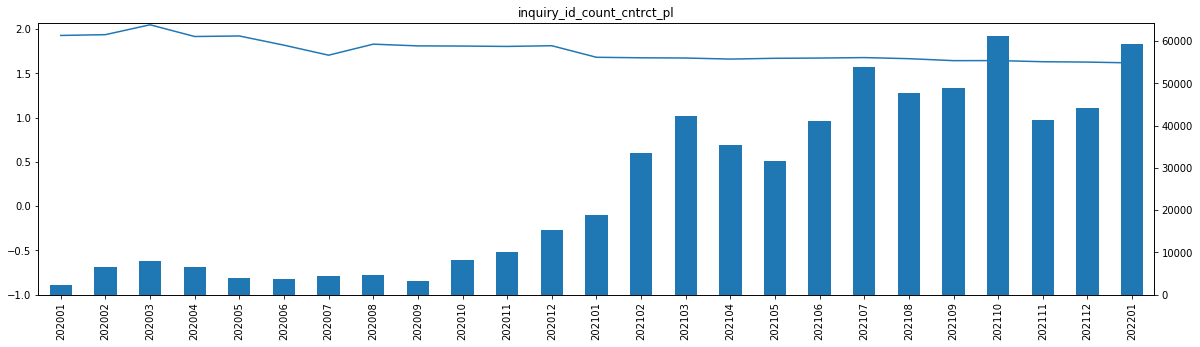

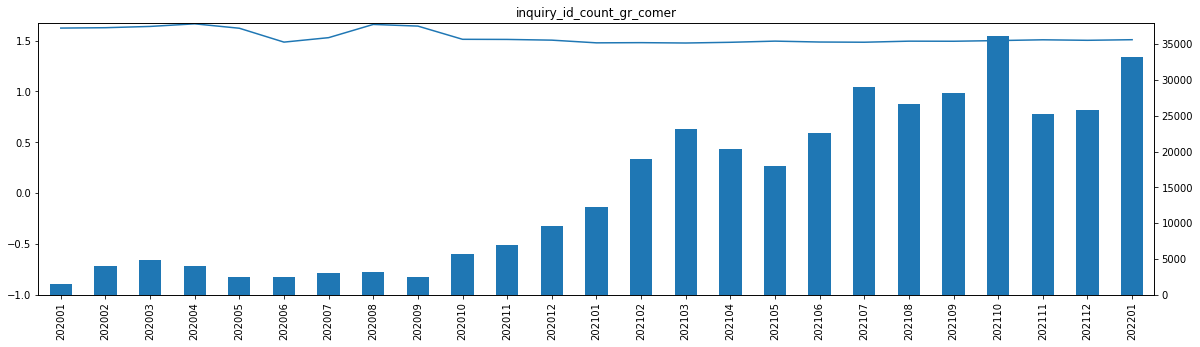

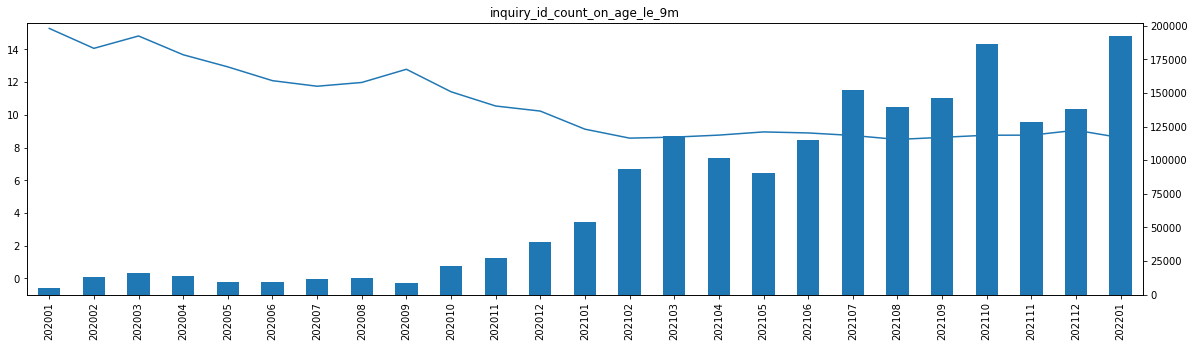

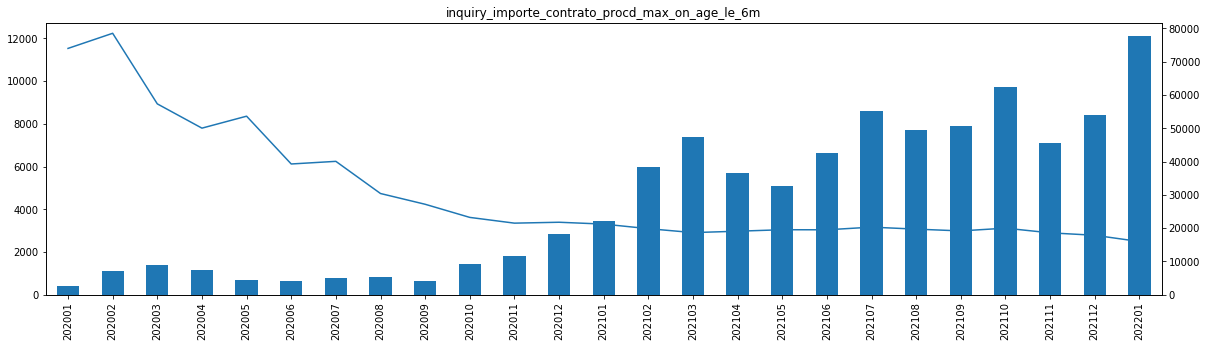

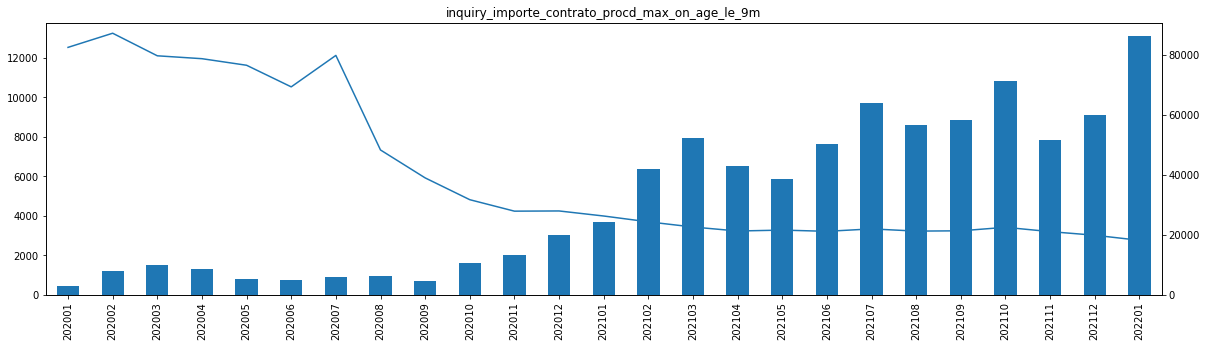

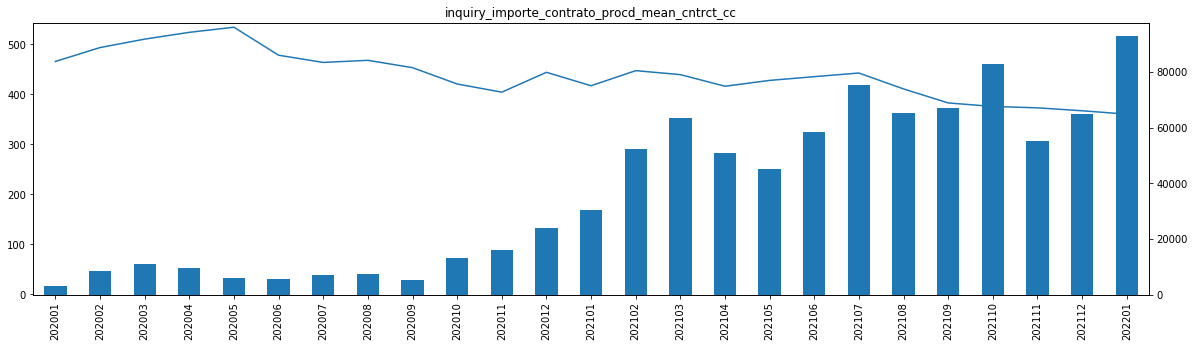

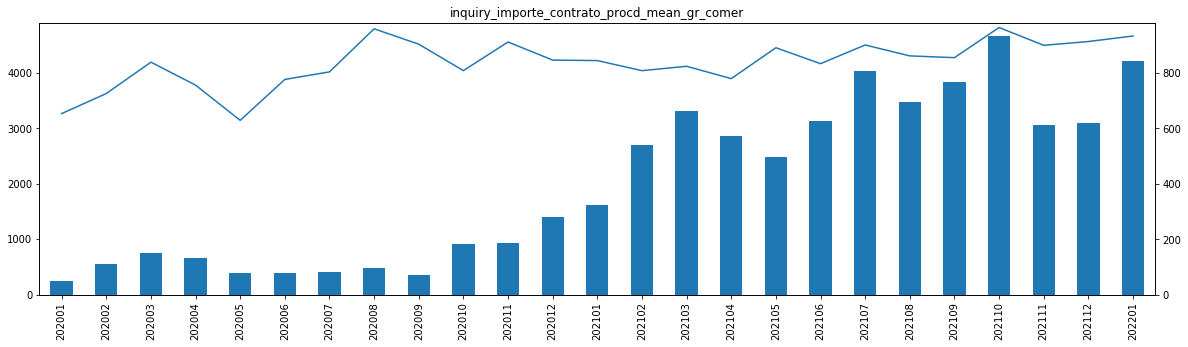

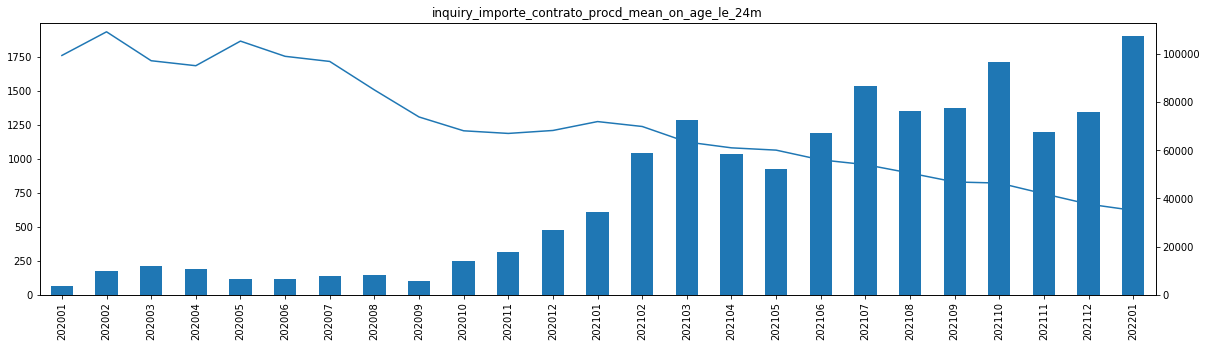

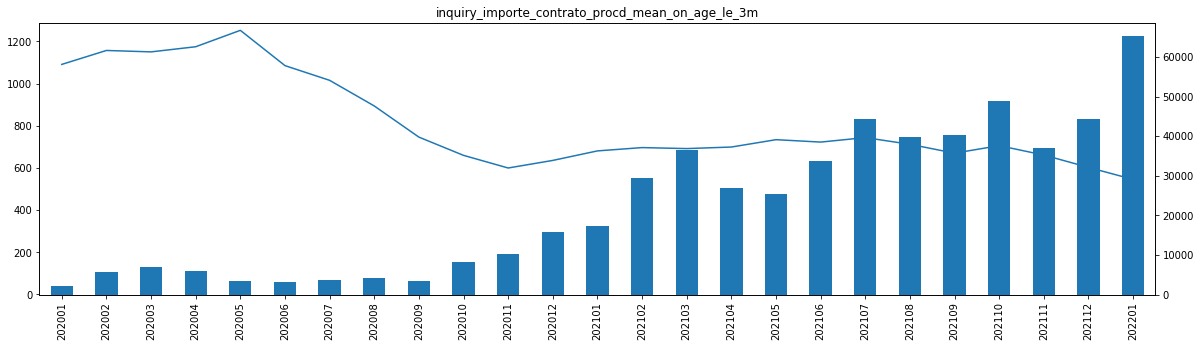

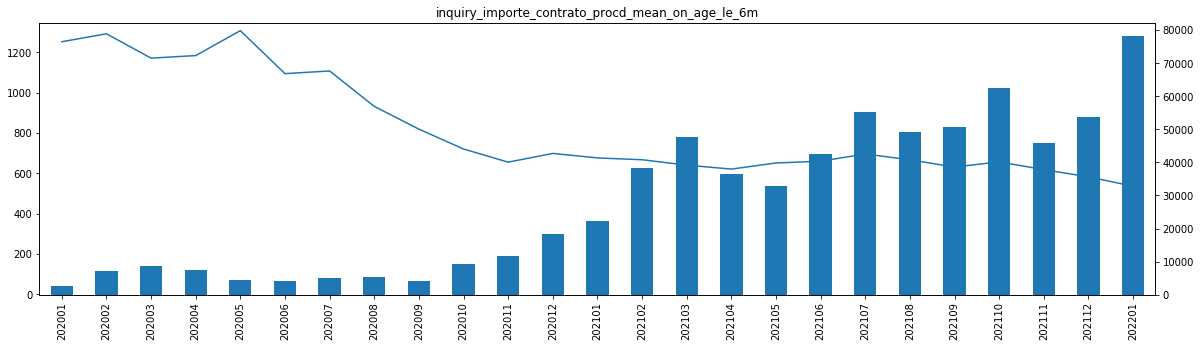

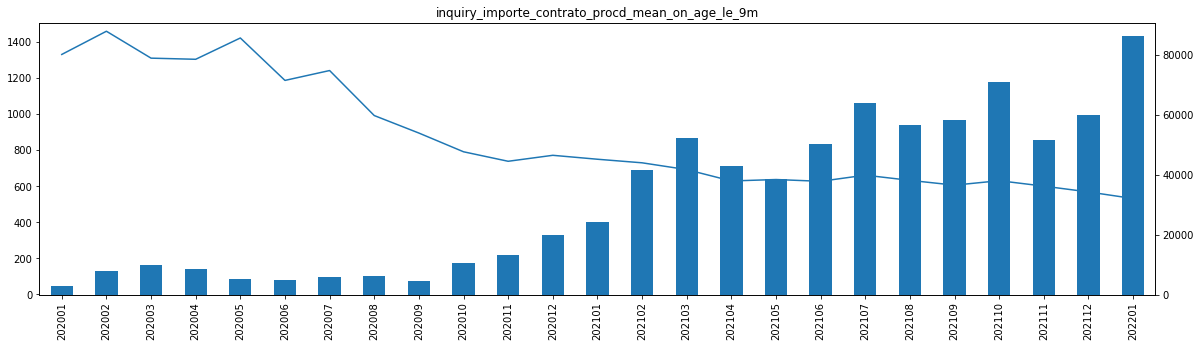

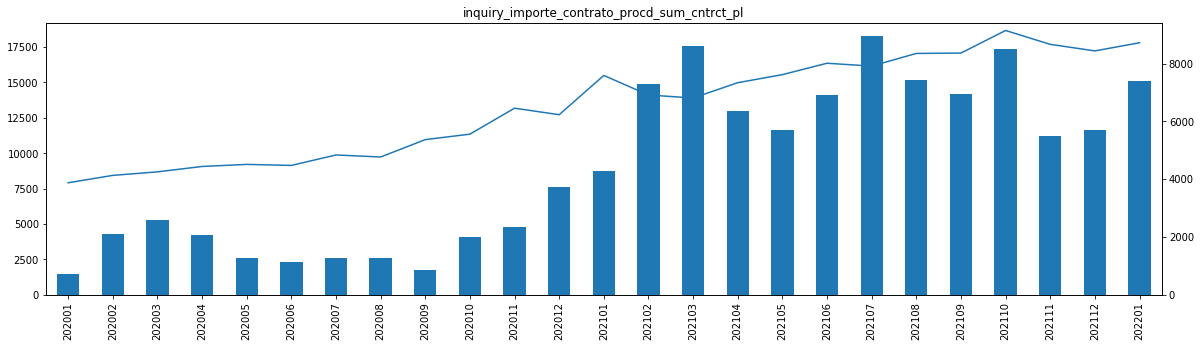

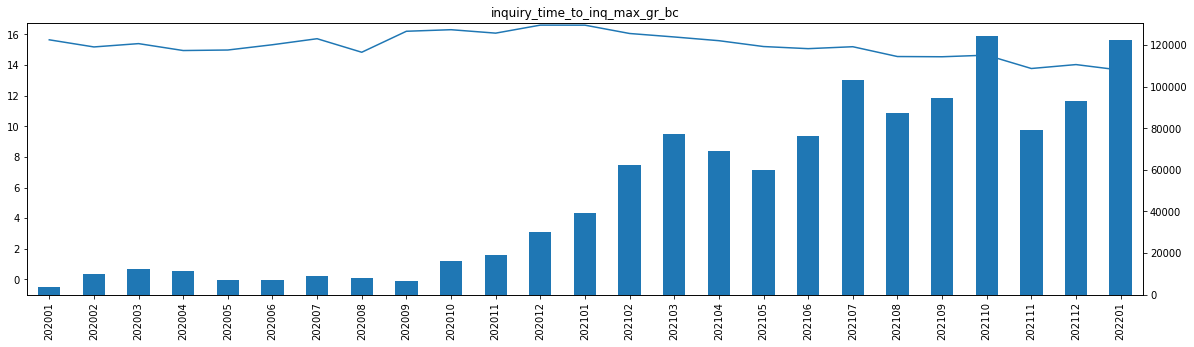

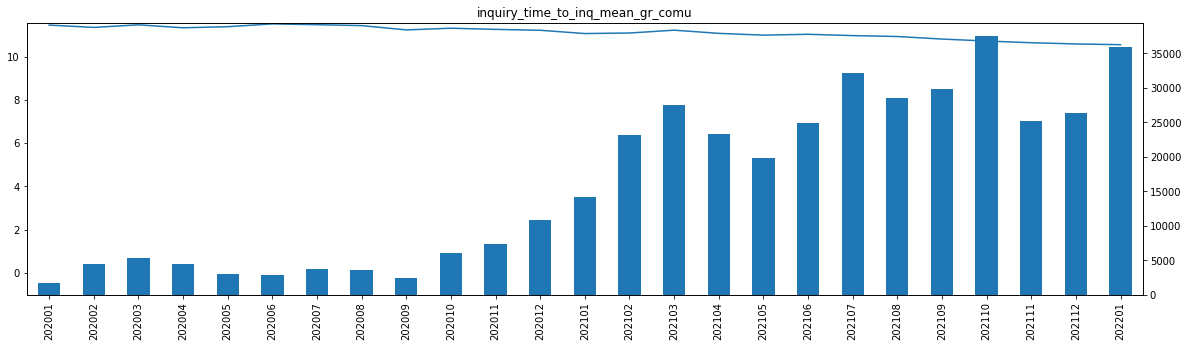

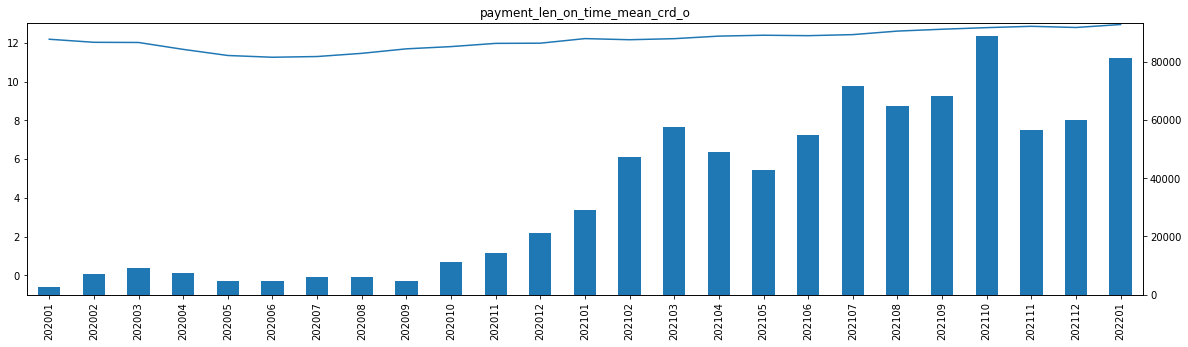

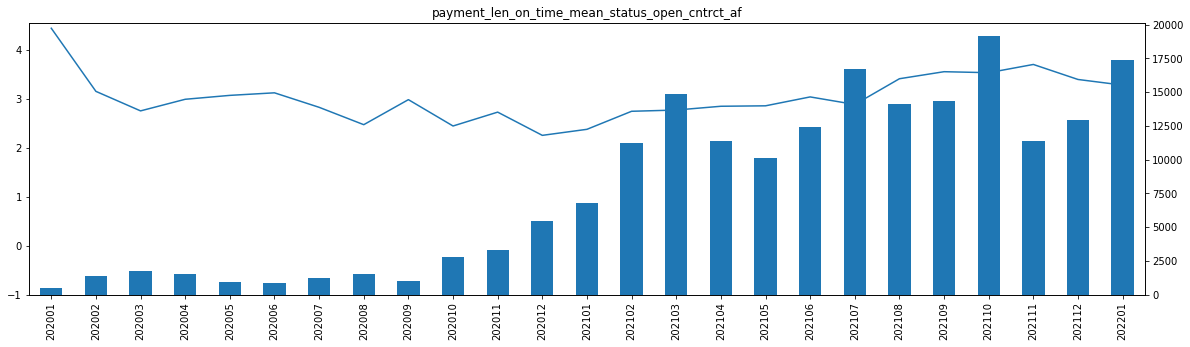

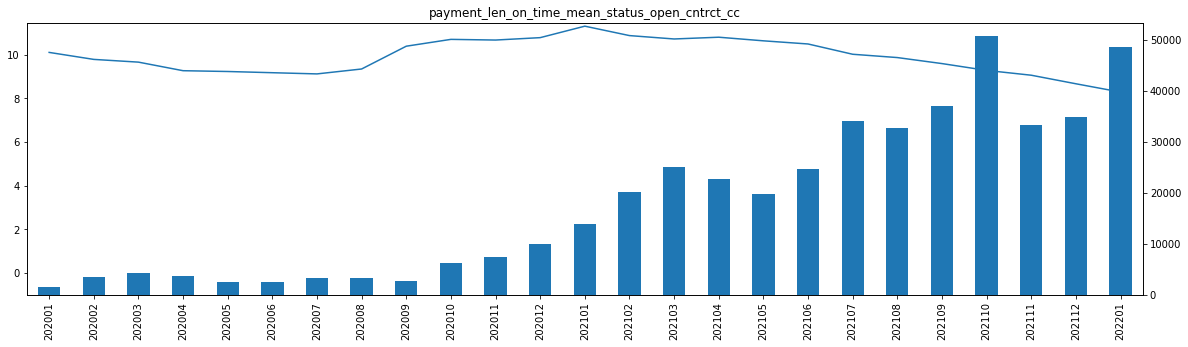

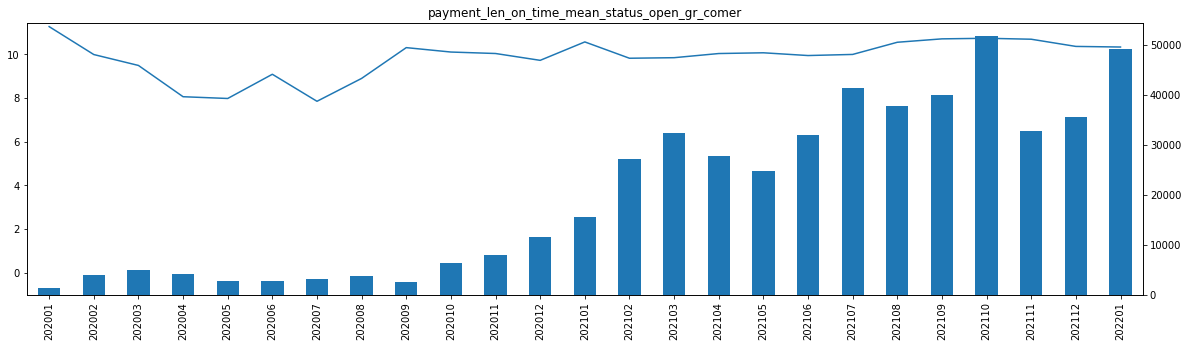

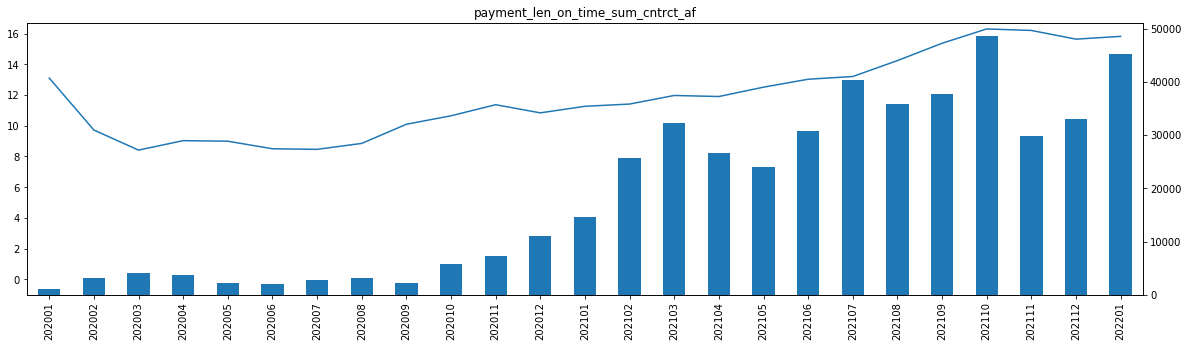

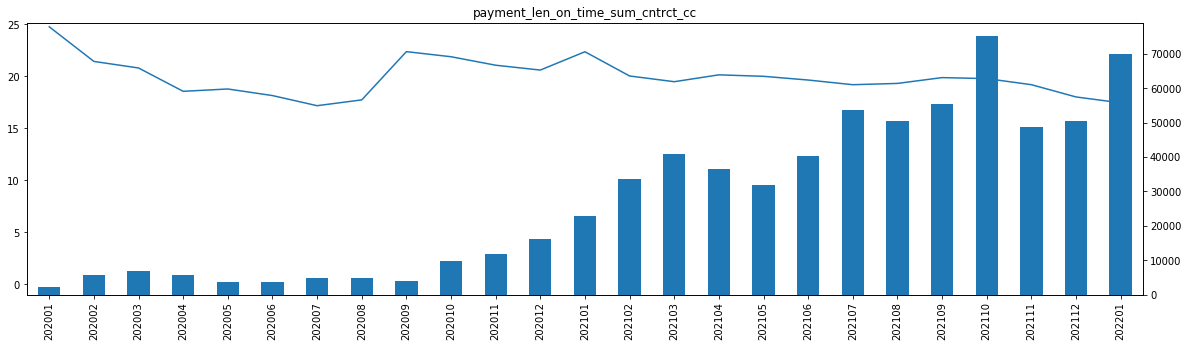

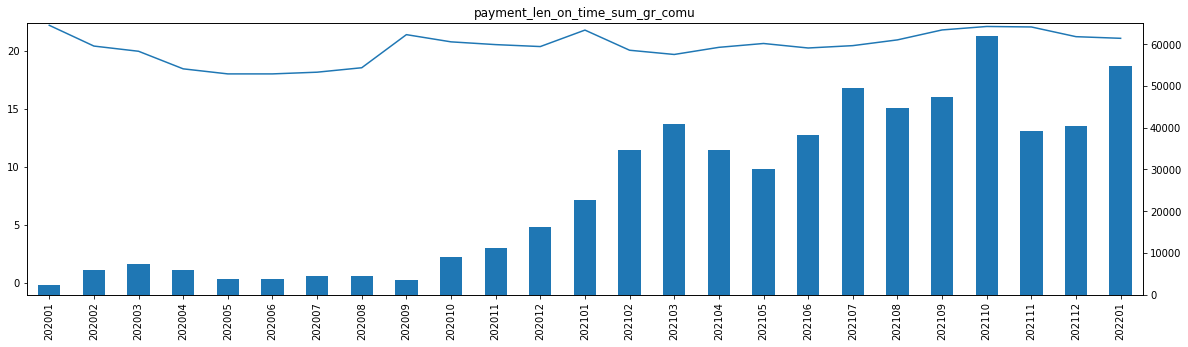

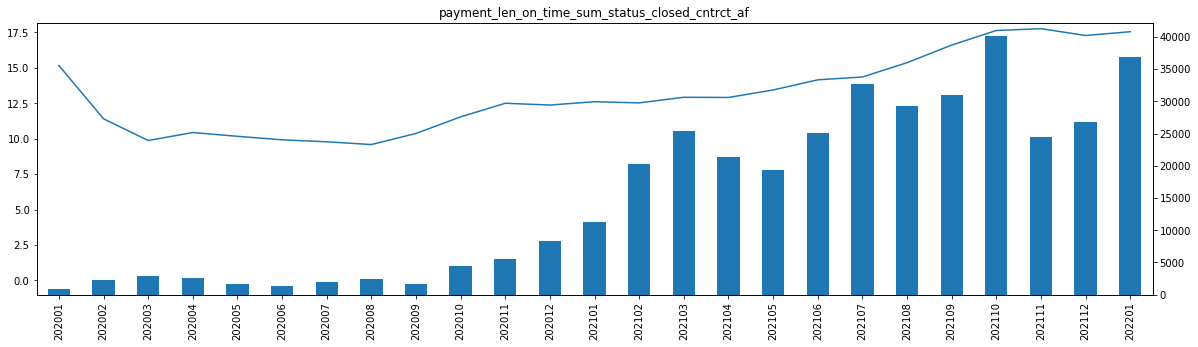

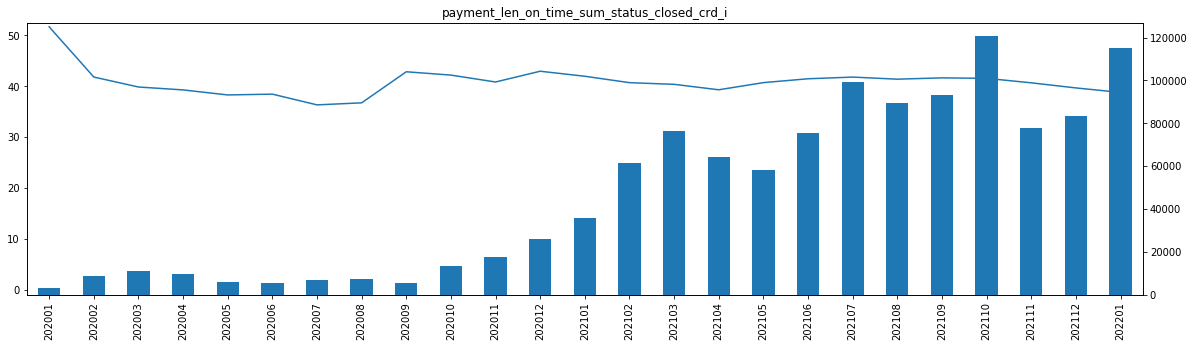

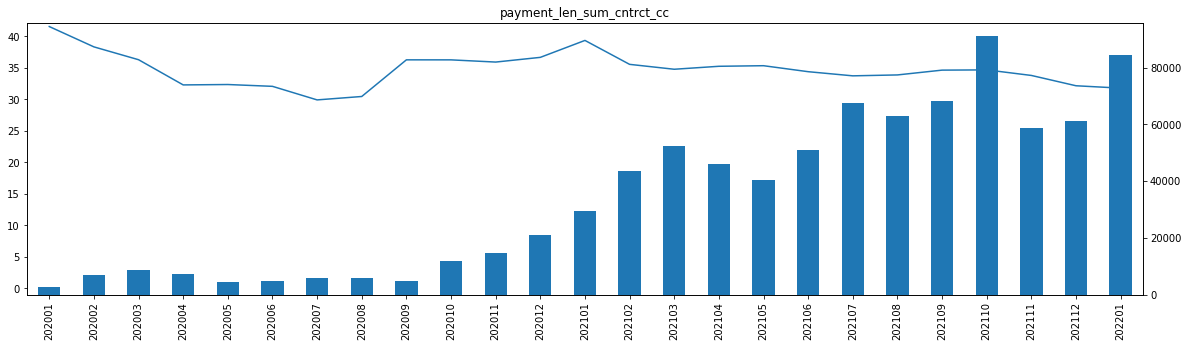

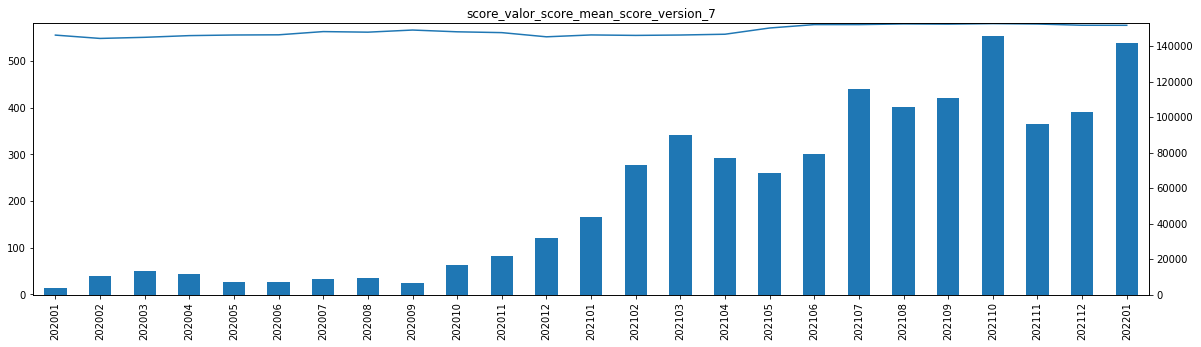

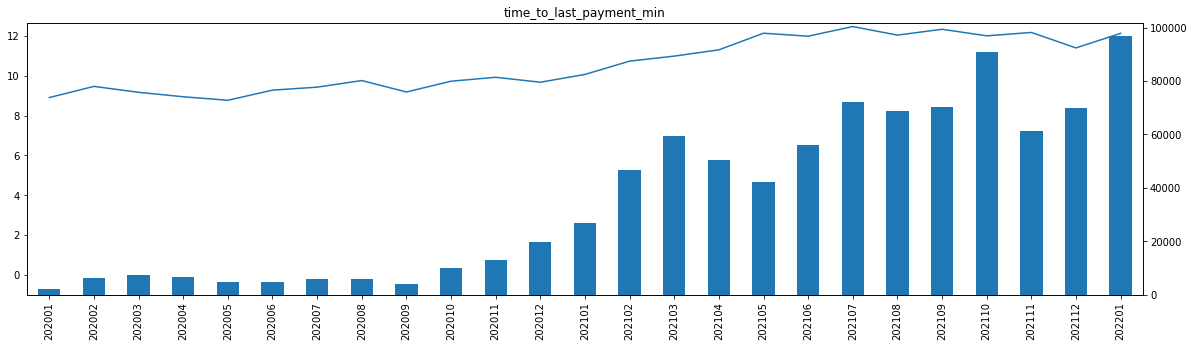

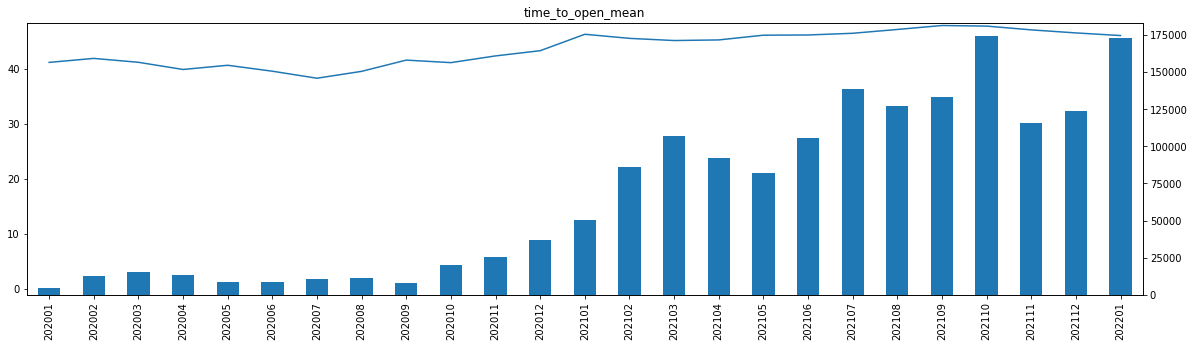

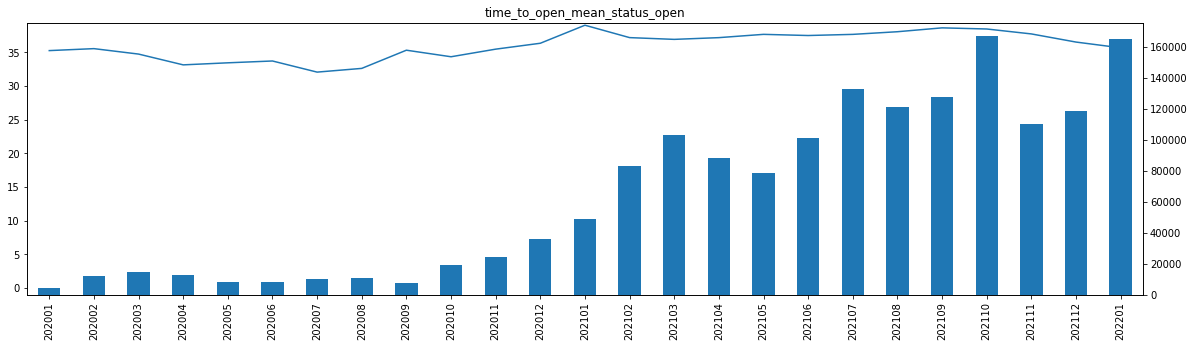

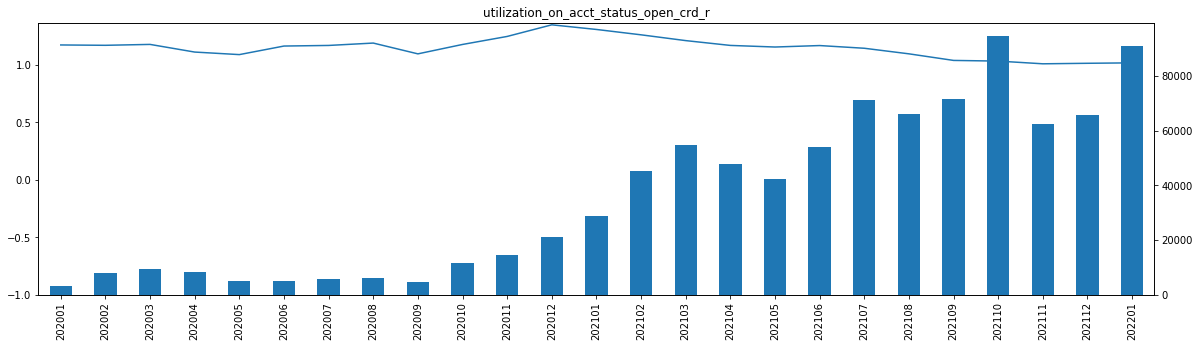

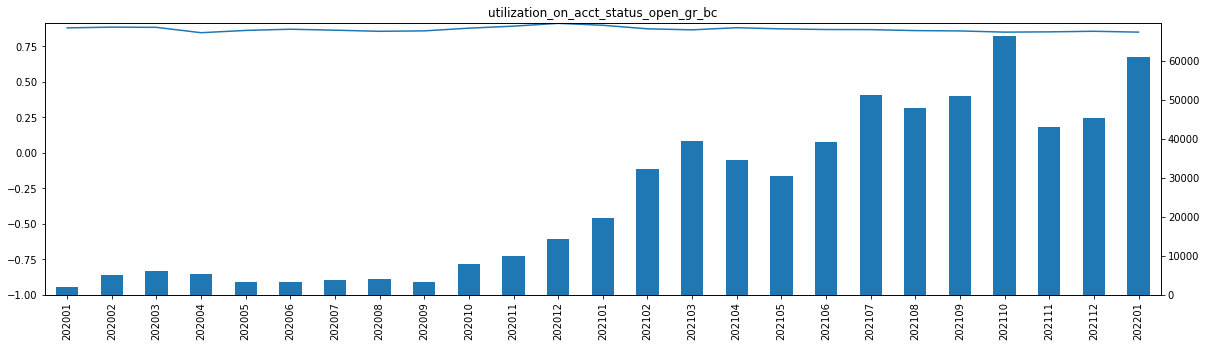

In [131]:
import matplotlib.pyplot as plt
inquiry_features = list(ecrm_all.columns[1:81])
inquiry_features.sort()
for f in inquiry_features:
    fig, ax = plt.subplots(figsize=(20,5))
    ax1 = ax.twinx()
    max_ = ecrm_all[ecrm_all[f]>0][[f, 'month_of_year']].groupby('month_of_year').quantile(0.95).sort_values('month_of_year').reset_index()
    plt_df_raw = ecrm_all[[f, 'month_of_year']].merge(max_, on='month_of_year', suffixes=['', '_max'])
    # remove outlier by removing the max. 
    plt_df = plt_df_raw[(plt_df_raw[f]>0)&(plt_df_raw[f]<(plt_df_raw[f'{f}_max']))].groupby('month_of_year')[[f]].mean().sort_values('month_of_year').reset_index()
    _=plt_df[f].plot(ax=ax)
    _=plt.xticks(np.arange(ecrm_all.month_of_year.nunique()))
    plt_df = plt_df_raw[(plt_df_raw[f]>0)&(plt_df_raw[f]<(plt_df_raw[f'{f}_max']))].groupby('month_of_year').agg({f:'size'}).sort_values('month_of_year').reset_index()
    _=plt_df[f].plot.bar(ax=ax1)
    _=plt.xticks(np.arange(ecrm_all.month_of_year.nunique()))
    start, end = ax.get_ylim()
    _=ax.set_ylim(-1, end)
#     _=ax.xaxis.set_ticks(np.arange(start, end, 1))
    label = list(plt_df.month_of_year)
    label.sort()
    _=ax.set_xticklabels(label, rotation=90)
    _=ax.set_title(f)
    

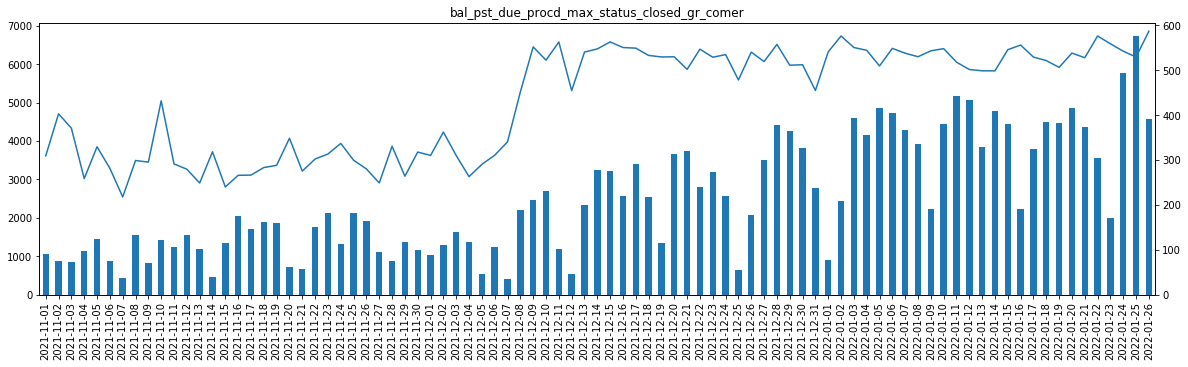

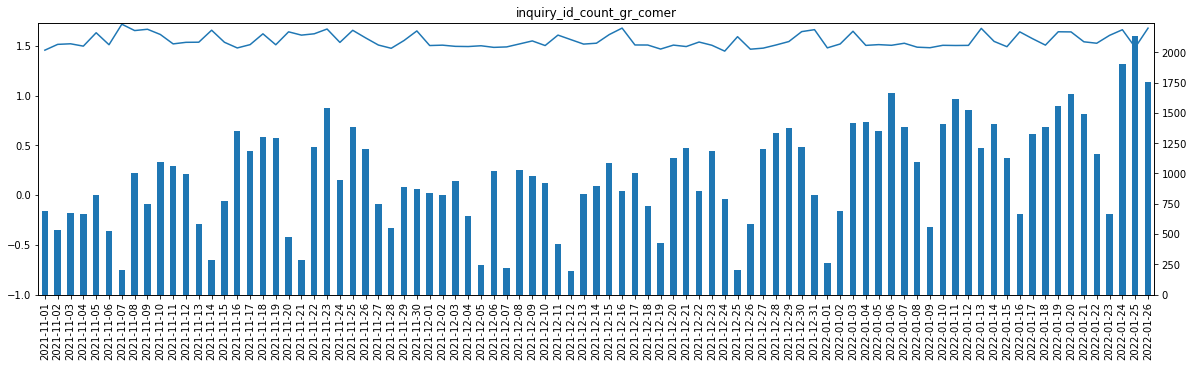

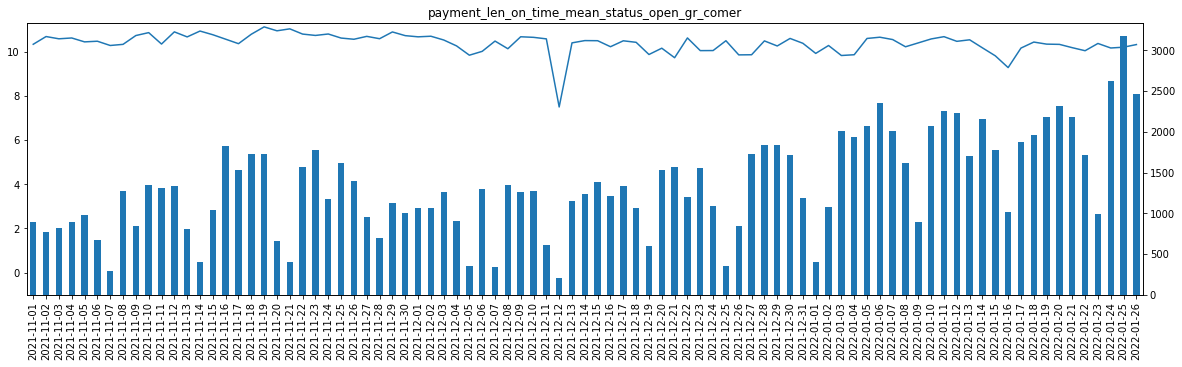

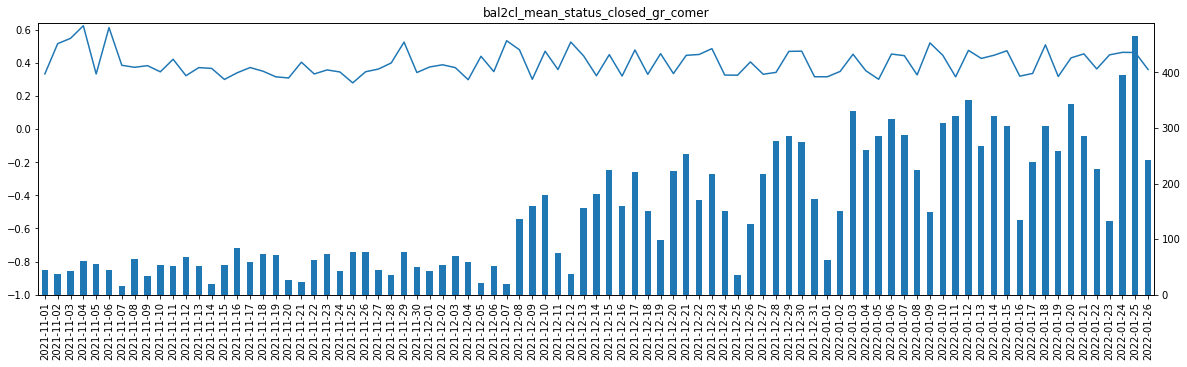

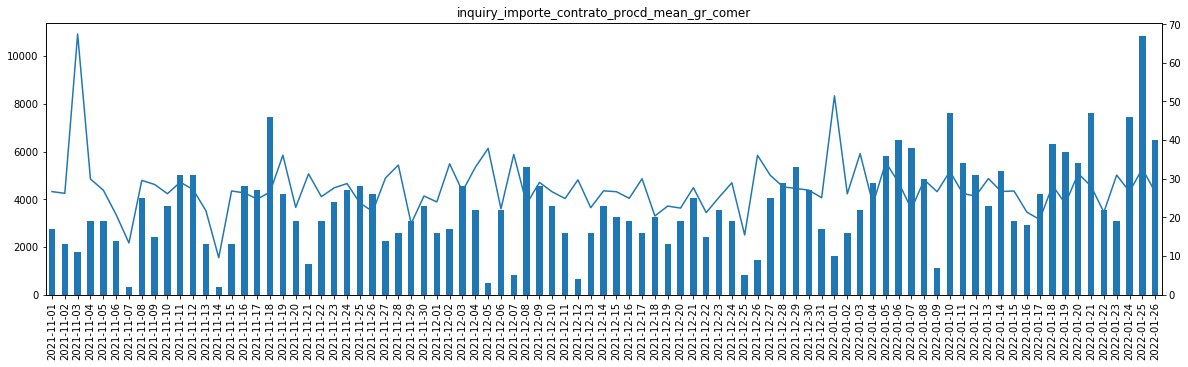

In [147]:
import matplotlib.pyplot as plt
# inquiry_features = list(ecrm_all.columns[1:81])
# inquiry_features.sort()
inquiry_features =[x for x in ecrm_all.columns if 'gr_comer' in x]
for f in inquiry_features:
    fig, ax = plt.subplots(figsize=(20,5))
    ax1 = ax.twinx()
    max_ = ecrm_all[ecrm_all[f]>0][[f, 'date_of_year']].groupby('date_of_year').quantile(0.95).sort_values('date_of_year').reset_index()
    plt_df_raw = ecrm_all[ecrm_all.date_of_year>='2021-11-01'][[f, 'date_of_year']].merge(max_, on='date_of_year', suffixes=['', '_max'])
    # remove outlier by removing the max. 
    plt_df = plt_df_raw[(plt_df_raw[f]>0)&(plt_df_raw[f]<(plt_df_raw[f'{f}_max']))].groupby('date_of_year')[[f]].mean().sort_values('date_of_year').reset_index()
    _=plt_df[f].plot(ax=ax)
    _=plt.xticks(np.arange(ecrm_all.date_of_year.nunique()))
    plt_df = plt_df_raw[(plt_df_raw[f]>0)&(plt_df_raw[f]<(plt_df_raw[f'{f}_max']))].groupby('date_of_year').agg({f:'size'}).sort_values('date_of_year').reset_index()
    _=plt_df[f].plot.bar(ax=ax1)
    _=plt.xticks(np.arange(plt_df_raw.date_of_year.nunique()))
    start, end = ax.get_ylim()
    _=ax.set_ylim(-1, end)
#     _=ax.xaxis.set_ticks(np.arange(start, end, 1))
    label = list(plt_df.date_of_year)
    label.sort()
    _=ax.set_xticklabels(label, rotation=90)
    _=ax.set_title(f)
    
    